In [132]:

# ============================================================================
# Handwritten Letter Recognition: KNN vs Neural Network
# Ultimate Comprehensive Analysis with Maximum Data Cleaning & Visualization
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             ConfusionMatrixDisplay)
from sklearn.decomposition import PCA
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for professional visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


In [137]:
# ============================================================================
# 1. DATA LOADING AND INITIAL EXPLORATION
# ============================================================================

print("="*80)
print("HANDWRITTEN LETTER RECOGNITION ANALYSIS")
print("Enhanced Data Cleaning & Comprehensive Visualization")
print("="*80)

# Load dataset
df = pd.read_csv("letters.csv")

print("\n1. DATASET OVERVIEW")
print("-" * 80)
print(f"Dataset Shape: {df.shape}")
print(f"Total Records: {df.shape[0]:,}")
print(f"Total Features: {df.shape[1]-1}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\nFirst 10 rows:")
print(df.head(10))

print(f"\nLast 5 rows:")
print(df.tail())

print("\nColumn Names:")
print(df.columns.tolist())

print("\nDataset Info:")
print(df.info())

# Random sample
print("\nRandom Sample (5 rows):")
print(df.sample(5, random_state=42))


HANDWRITTEN LETTER RECOGNITION ANALYSIS
Enhanced Data Cleaning & Comprehensive Visualization

1. DATASET OVERVIEW
--------------------------------------------------------------------------------
Dataset Shape: (42000, 46)
Total Records: 42,000
Total Features: 45
Memory Usage: 14.74 MB

First 10 rows:
   label  pixel43  pixel44  pixel92  pixel124  pixel125  pixel126  pixel127  \
0      1        0        0        0         0         0         0         0   
1      0        0        0        0       137       137       192        86   
2      1        0        0        0         3       141       139         3   
3      4        0        0        0         0         0         0         0   
4      0        0        0        0       155       254       254       254   
5      0        0        0        0         3       141       202       254   
6      7        0        0        0         0         0         0         0   
7      3        0        0        0         0         0         0 


2. COMPREHENSIVE DATA QUALITY ASSESSMENT & CLEANING
--------------------------------------------------------------------------------
Original dataset size: 42,000 rows

[Step 1] Missing Values Check:
✓ No missing values detected

[Step 2] Duplicate Rows Check:
Duplicate rows found: 1633
→ Removing 1633 duplicate rows...
✓ Dataset size after duplicate removal: 40,367 rows

[Step 3] Data Types Validation:
int64    46
Name: count, dtype: int64

Validating all features are numeric...
✓ All features are numeric

[Step 4] Infinite Values Check:
✓ No infinite values detected

[Step 5] Value Range Validation:
Global value range: [0.00, 255.00]

[Step 6] Target Variable Validation:
Target column: 'label'
Unique values: 10
Value distribution:
label
1    4636
3    4282
2    4139
6    4137
0    4132
8    4049
4    4037
7    3980
9    3844
5    3131
Name: count, dtype: int64

[Cleaning Summary]
Original rows: 42,000
Final rows: 40,367
Rows removed: 1,633 (3.89%)
✓ Data cleaning complete

[Step 7] 

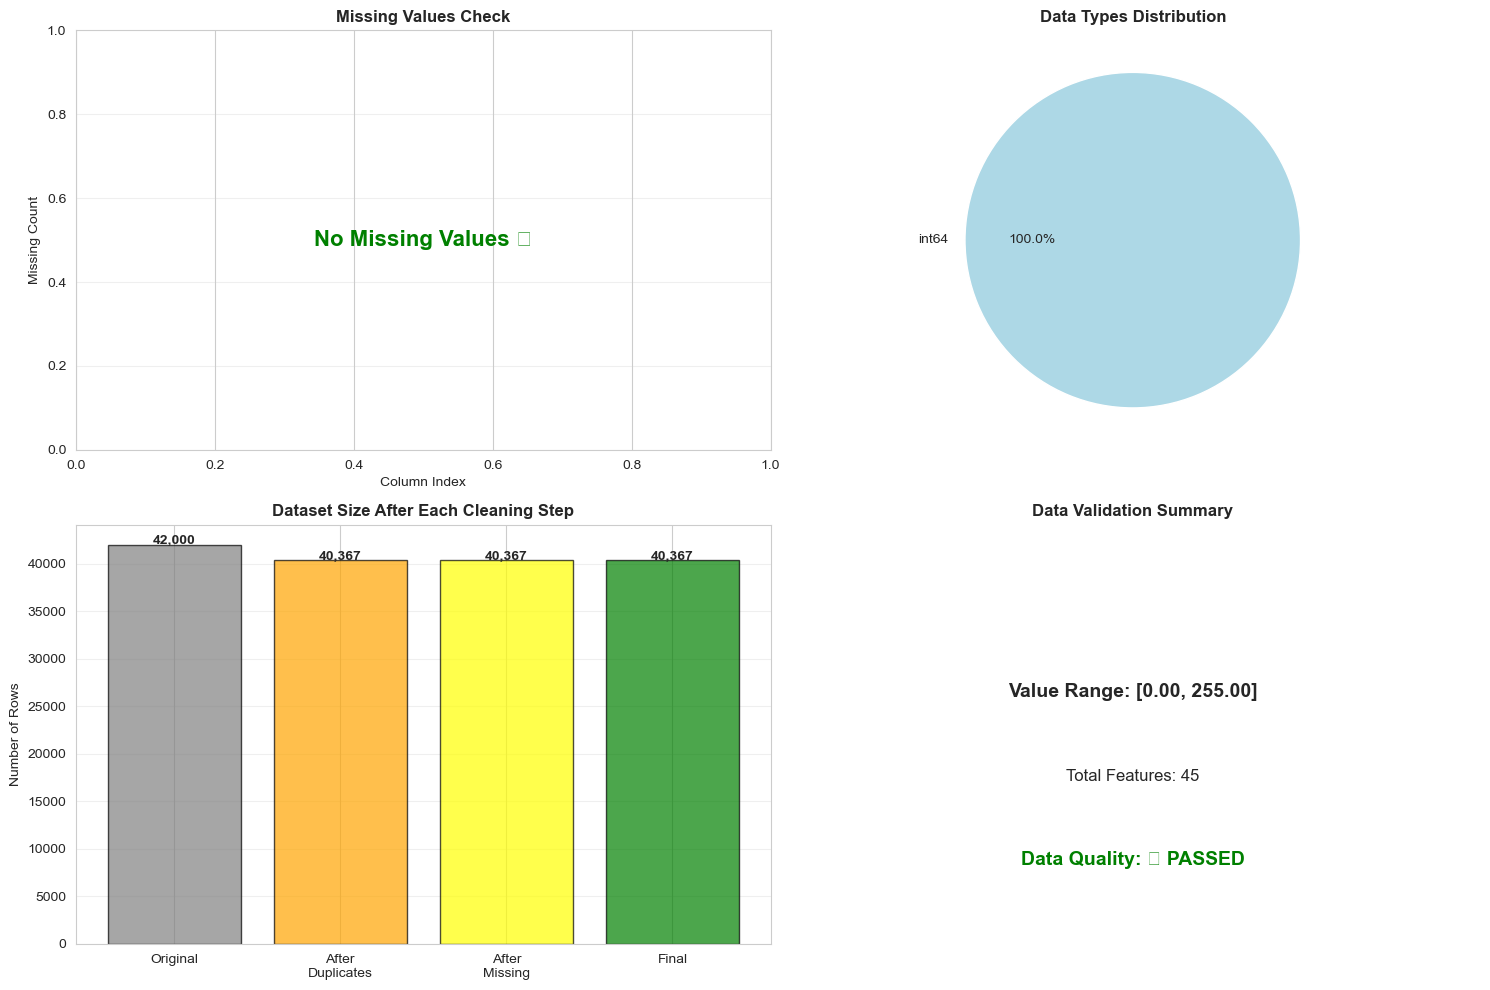

In [139]:
# ============================================================================
# 2. COMPREHENSIVE DATA QUALITY ASSESSMENT & CLEANING
# ============================================================================

print("\n2. COMPREHENSIVE DATA QUALITY ASSESSMENT & CLEANING")
print("-" * 80)

# Store original dataset size
original_size = len(df)
print(f"Original dataset size: {original_size:,} rows")

# 2.1 Missing Values
print("\n[Step 1] Missing Values Check:")
missing_vals = df.isnull().sum()
if missing_vals.sum() == 0:
    print("✓ No missing values detected")
else:
    print("⚠ Missing values found:")
    print(missing_vals[missing_vals > 0])
    print(f"\nTotal missing: {missing_vals.sum()} ({missing_vals.sum()/df.size*100:.2f}%)")
    # Handle missing values
    df = df.dropna()
    print(f"→ Removed rows with missing values")
    print(f"  New size: {len(df):,} rows")

# 2.2 Duplicate Rows
print("\n[Step 2] Duplicate Rows Check:")
duplicates = df.duplicated().sum()
print(f"Duplicate rows found: {duplicates}")
if duplicates > 0:
    print(f"→ Removing {duplicates} duplicate rows...")
    df = df.drop_duplicates()
    print(f"✓ Dataset size after duplicate removal: {len(df):,} rows")

# 2.3 Data Types Validation
print("\n[Step 3] Data Types Validation:")
print(df.dtypes.value_counts())

target_col = df.columns[0]
feature_cols = df.columns[1:]

print(f"\nValidating all features are numeric...")
non_numeric_cols = []
for col in feature_cols:
    if df[col].dtype == 'object':
        non_numeric_cols.append(col)
        print(f"  ⚠ {col} contains non-numeric values")

if len(non_numeric_cols) == 0:
    print("✓ All features are numeric")
else:
    print(f"\n→ Converting {len(non_numeric_cols)} columns to numeric...")
    for col in non_numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 2.4 Infinite Values
print("\n[Step 4] Infinite Values Check:")
inf_count = np.isinf(df[feature_cols].select_dtypes(include=[np.number])).sum().sum()
if inf_count > 0:
    print(f"⚠ Found {inf_count} infinite values")
    print(f"→ Replacing infinite values with NaN...")
    df[feature_cols] = df[feature_cols].replace([np.inf, -np.inf], np.nan)
    # Drop rows with NaN created from inf
    df = df.dropna()
    print(f"✓ New dataset size: {len(df):,} rows")
else:
    print("✓ No infinite values detected")

# 2.5 Invalid Values (negative values in pixel data if applicable)
print("\n[Step 5] Value Range Validation:")
numeric_features = df[feature_cols].select_dtypes(include=[np.number])
min_val = numeric_features.min().min()
max_val = numeric_features.max().max()
print(f"Global value range: [{min_val:.2f}, {max_val:.2f}]")

if min_val < 0:
    print(f"⚠ Negative values detected (might be invalid for pixel data)")
    negative_count = (numeric_features < 0).sum().sum()
    print(f"  Total negative values: {negative_count}")

# 2.6 Check target variable validity
print("\n[Step 6] Target Variable Validation:")
print(f"Target column: '{target_col}'")
print(f"Unique values: {df[target_col].nunique()}")
print(f"Value distribution:")
print(df[target_col].value_counts().head(10))

# Check for unexpected characters
if df[target_col].dtype == 'object':
    unique_targets = df[target_col].unique()
    print(f"\nAll unique target values: {sorted(unique_targets)}")

# 2.7 Final cleaning summary
rows_removed = original_size - len(df)
print(f"\n[Cleaning Summary]")
print(f"Original rows: {original_size:,}")
print(f"Final rows: {len(df):,}")
print(f"Rows removed: {rows_removed:,} ({rows_removed/original_size*100:.2f}%)")
print("✓ Data cleaning complete")

# Descriptive Statistics
print("\n[Step 7] Descriptive Statistics:")
print(df.describe())

# Visualization 1: Data Quality Report
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Missing values visualization
missing_counts = df.isnull().sum()
if missing_counts.sum() > 0:
    axes[0, 0].bar(range(len(missing_counts[:20])), missing_counts[:20], color='red')
    axes[0, 0].set_title('Missing Values by Column (First 20)', fontweight='bold')
else:
    axes[0, 0].text(0.5, 0.5, 'No Missing Values ✓', 
                    ha='center', va='center', fontsize=16, color='green', fontweight='bold')
    axes[0, 0].set_title('Missing Values Check', fontweight='bold')
axes[0, 0].set_xlabel('Column Index')
axes[0, 0].set_ylabel('Missing Count')
axes[0, 0].grid(axis='y', alpha=0.3)

# Data types distribution
dtype_counts = df.dtypes.value_counts()
axes[0, 1].pie(dtype_counts, labels=dtype_counts.index, autopct='%1.1f%%', 
               colors=['lightblue', 'lightcoral', 'lightgreen'])
axes[0, 1].set_title('Data Types Distribution', fontweight='bold')

# Dataset size evolution
cleaning_steps = ['Original', 'After\nDuplicates', 'After\nMissing', 'Final']
sizes = [original_size, original_size - duplicates, 
         original_size - duplicates, len(df)]
axes[1, 0].bar(cleaning_steps, sizes, color=['gray', 'orange', 'yellow', 'green'], 
               edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Dataset Size After Each Cleaning Step', fontweight='bold')
axes[1, 0].set_ylabel('Number of Rows')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(sizes):
    axes[1, 0].text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

# Value range check
axes[1, 1].text(0.5, 0.6, f'Value Range: [{min_val:.2f}, {max_val:.2f}]',
                ha='center', va='center', fontsize=14, fontweight='bold')
axes[1, 1].text(0.5, 0.4, f'Total Features: {len(feature_cols)}',
                ha='center', va='center', fontsize=12)
axes[1, 1].text(0.5, 0.2, f'Data Quality: ✓ PASSED',
                ha='center', va='center', fontsize=14, color='green', fontweight='bold')
axes[1, 1].set_title('Data Validation Summary', fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('01_data_quality_report.png', dpi=300, bbox_inches='tight')
plt.show()


3. TARGET VARIABLE ANALYSIS
--------------------------------------------------------------------------------
Target Variable: 'label'
Unique Classes: 10
Expected Classes: 26 (A-Z)

Class Distribution:
label
0    4132
1    4636
2    4139
3    4282
4    4037
5    3131
6    4137
7    3980
8    4049
9    3844
Name: count, dtype: int64

Class Balance Statistics:
  Min count: 3131
  Max count: 4636
  Mean count: 4036.70
  Median count: 4090.50
  Std deviation: 381.48
  Coefficient of Variation: 0.0945


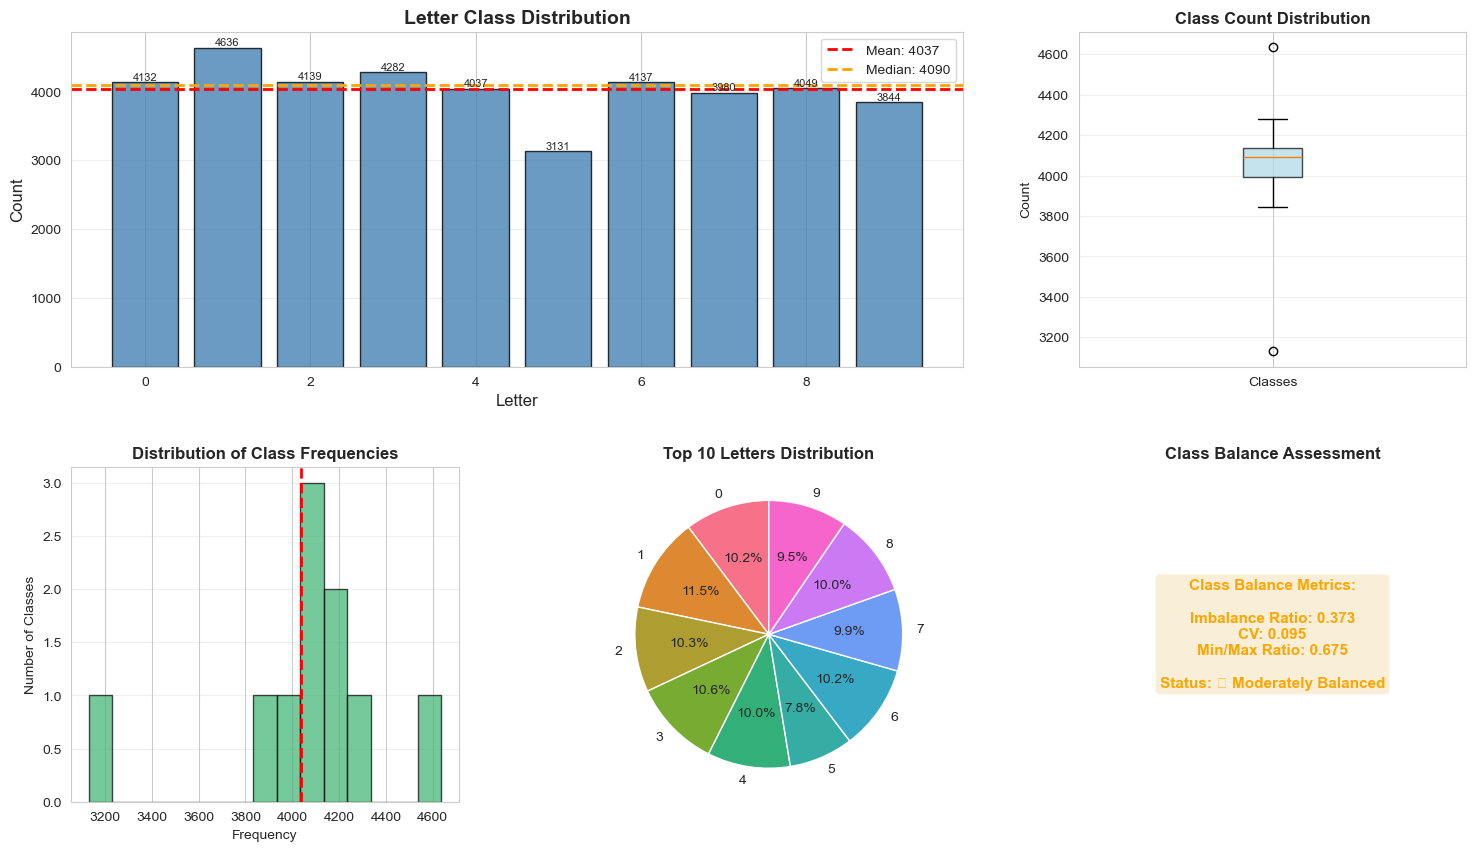

In [111]:
# ============================================================================
# 3. TARGET VARIABLE ANALYSIS
# ============================================================================

print("\n3. TARGET VARIABLE ANALYSIS")
print("-" * 80)

print(f"Target Variable: '{target_col}'")
print(f"Unique Classes: {df[target_col].nunique()}")
print(f"Expected Classes: 26 (A-Z)")

print(f"\nClass Distribution:")
class_dist = df[target_col].value_counts().sort_index()
print(class_dist)

# Class statistics
print(f"\nClass Balance Statistics:")
print(f"  Min count: {class_dist.min()}")
print(f"  Max count: {class_dist.max()}")
print(f"  Mean count: {class_dist.mean():.2f}")
print(f"  Median count: {class_dist.median():.2f}")
print(f"  Std deviation: {class_dist.std():.2f}")
print(f"  Coefficient of Variation: {class_dist.std()/class_dist.mean():.4f}")

# Visualization 2: Enhanced Class Distribution
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Bar plot with mean line
ax1 = fig.add_subplot(gs[0, :2])
bars = ax1.bar(class_dist.index, class_dist.values, color='steelblue', 
               edgecolor='black', alpha=0.8)
ax1.axhline(y=class_dist.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {class_dist.mean():.0f}')
ax1.axhline(y=class_dist.median(), color='orange', linestyle='--', linewidth=2,
            label=f'Median: {class_dist.median():.0f}')
ax1.set_title('Letter Class Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Letter', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=8)

# Box plot of class distribution
ax2 = fig.add_subplot(gs[0, 2])
ax2.boxplot([class_dist.values], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', alpha=0.7))
ax2.set_title('Class Count Distribution', fontsize=12, fontweight='bold')
ax2.set_ylabel('Count', fontsize=10)
ax2.set_xticklabels(['Classes'])
ax2.grid(axis='y', alpha=0.3)

# Histogram of class frequencies
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(class_dist.values, bins=15, color='mediumseagreen', 
         edgecolor='black', alpha=0.7)
ax3.axvline(class_dist.mean(), color='red', linestyle='--', linewidth=2)
ax3.set_title('Distribution of Class Frequencies', fontsize=12, fontweight='bold')
ax3.set_xlabel('Frequency', fontsize=10)
ax3.set_ylabel('Number of Classes', fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# Pie chart - top 10
ax4 = fig.add_subplot(gs[1, 1])
ax4.pie(class_dist.head(10), labels=class_dist.head(10).index, 
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette("husl", 10))
ax4.set_title('Top 10 Letters Distribution', fontsize=12, fontweight='bold')

# Class imbalance metrics
ax5 = fig.add_subplot(gs[1, 2])
imbalance_ratio = (class_dist.max() - class_dist.min()) / class_dist.mean()
cv = class_dist.std() / class_dist.mean()

metrics_text = f"Class Balance Metrics:\n\n"
metrics_text += f"Imbalance Ratio: {imbalance_ratio:.3f}\n"
metrics_text += f"CV: {cv:.3f}\n"
metrics_text += f"Min/Max Ratio: {class_dist.min()/class_dist.max():.3f}\n\n"

if imbalance_ratio < 0.3:
    metrics_text += "Status: ✓ Well Balanced"
    color = 'green'
elif imbalance_ratio < 0.6:
    metrics_text += "Status: ⚠ Moderately Balanced"
    color = 'orange'
else:
    metrics_text += "Status: ⚠ Imbalanced"
    color = 'red'

ax5.text(0.5, 0.5, metrics_text, ha='center', va='center', 
         fontsize=11, fontweight='bold', color=color,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax5.set_title('Class Balance Assessment', fontsize=12, fontweight='bold')
ax5.axis('off')

plt.savefig('02_class_distribution_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()



4. ENHANCED FEATURE ANALYSIS AND CLEANING
--------------------------------------------------------------------------------
Feature Matrix Shape: (40367, 45)
Number of Features: 45

[Feature Check 1] Constant Features:
✓ No constant features found

[Feature Check 2] Low Variance Features:
✓ All features have variance >= 0.01

[Feature Check 3] Outlier Detection (IQR Method):
  Total outlier values: 162,403 / 1,816,515
  Percentage: 8.94%
  Features with most outliers:
pixel413    9860
pixel129    9707
pixel125    9483
pixel160    9424
pixel126    9173
pixel329    9054
pixel150    8897
pixel128    8775
pixel127    8465
pixel130    8450
dtype: int64

[Feature Check 4] Z-Score Outlier Detection (|z| > 3):
  Total outlier values: 21,217 / 1,816,515
  Percentage: 1.17%

[Feature Check 5] Feature Value Ranges:
  Global Min: 0.00
  Global Max: 255.00
  Global Mean: 39.33
  Global Median: 0.00
  Global Std: 67.61

[Feature Check 6] Skewness Analysis:
  Features with |skewness| > 1: 36
  Mean s

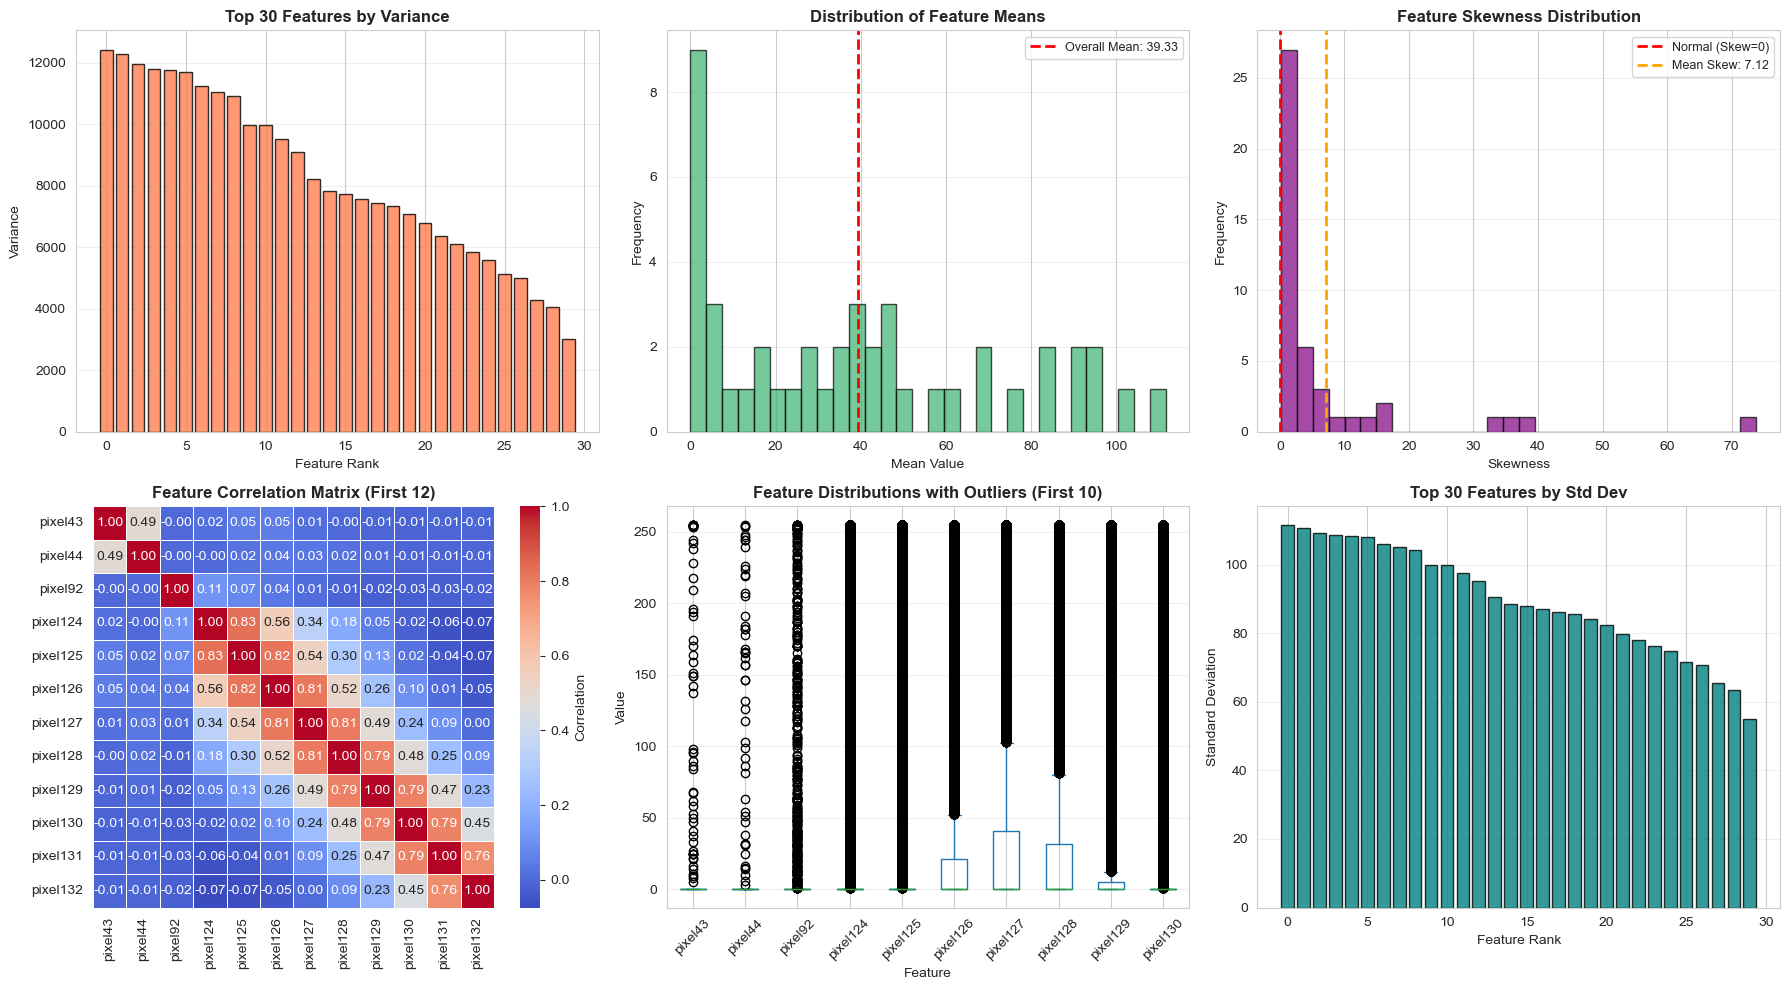

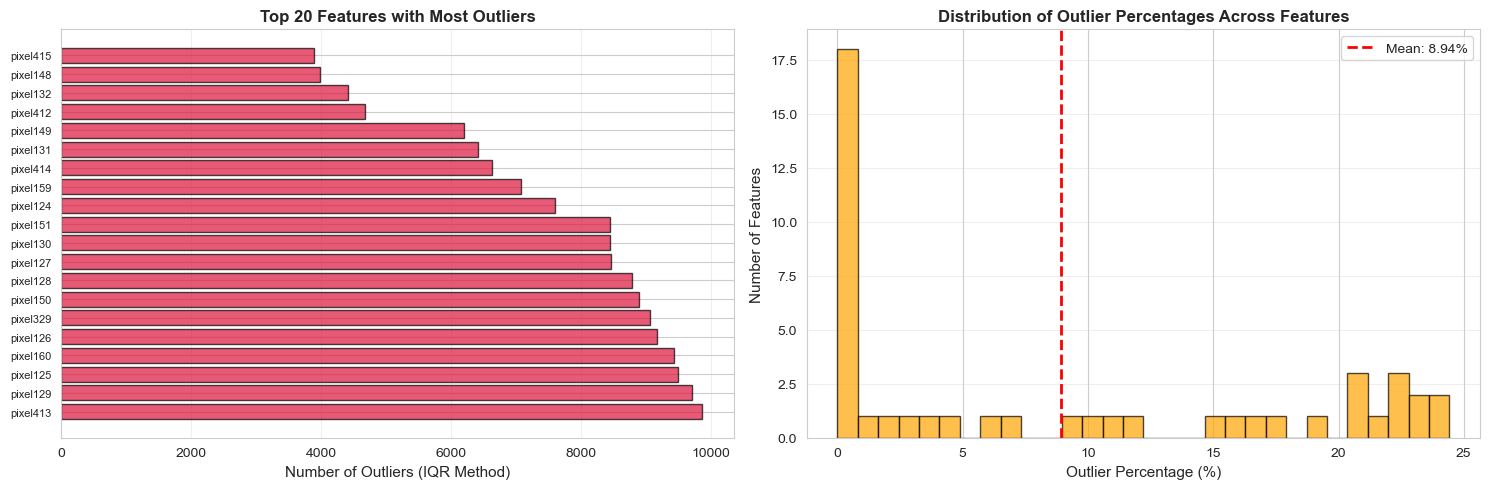

In [141]:
# ============================================================================
# 4. ENHANCED FEATURE ANALYSIS AND CLEANING
# ============================================================================

print("\n4. ENHANCED FEATURE ANALYSIS AND CLEANING")
print("-" * 80)

# Separate features and target
X = df.iloc[:, 1:].copy()
y = df.iloc[:, 0].copy()

print(f"Feature Matrix Shape: {X.shape}")
print(f"Number of Features: {X.shape[1]}")

# 4.1 Constant Features
print("\n[Feature Check 1] Constant Features:")
constant_features = X.columns[X.nunique() == 1]
if len(constant_features) > 0:
    print(f"⚠ Found {len(constant_features)} constant features")
    print(f"  Features: {list(constant_features)}")
    print(f"→ Removing constant features...")
    X = X.drop(columns=constant_features)
    print(f"✓ Features remaining: {X.shape[1]}")
else:
    print("✓ No constant features found")

# 4.2 Low Variance Features
print("\n[Feature Check 2] Low Variance Features:")
feature_variance = X.var()
low_var_threshold = 0.01
low_var_features = feature_variance[feature_variance < low_var_threshold].index
if len(low_var_features) > 0:
    print(f"⚠ Found {len(low_var_features)} low-variance features (var < {low_var_threshold})")
    print(f"  Top 10: {list(low_var_features[:10])}")
    print(f"  Note: Keeping for now but flagged for review")
else:
    print(f"✓ All features have variance >= {low_var_threshold}")

# 4.3 Outlier Detection (IQR Method)
print("\n[Feature Check 3] Outlier Detection (IQR Method):")
outlier_counts = {}
for col in X.columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((X[col] < (Q1 - 1.5 * IQR)) | (X[col] > (Q3 + 1.5 * IQR))).sum()
    outlier_counts[col] = outliers

total_outliers = sum(outlier_counts.values())
total_values = X.shape[0] * X.shape[1]
print(f"  Total outlier values: {total_outliers:,} / {total_values:,}")
print(f"  Percentage: {total_outliers/total_values*100:.2f}%")
print(f"  Features with most outliers:")
outlier_series = pd.Series(outlier_counts).sort_values(ascending=False)
print(outlier_series.head(10))

# 4.4 Z-Score Outlier Detection
print("\n[Feature Check 4] Z-Score Outlier Detection (|z| > 3):")
z_scores = np.abs(stats.zscore(X))
outliers_zscore = (z_scores > 3).sum().sum()
print(f"  Total outlier values: {outliers_zscore:,} / {total_values:,}")
print(f"  Percentage: {outliers_zscore/total_values*100:.2f}%")

# 4.5 Feature Statistics
print("\n[Feature Check 5] Feature Value Ranges:")
print(f"  Global Min: {X.min().min():.2f}")
print(f"  Global Max: {X.max().max():.2f}")
print(f"  Global Mean: {X.mean().mean():.2f}")
print(f"  Global Median: {X.median().median():.2f}")
print(f"  Global Std: {X.std().mean():.2f}")

# 4.6 Skewness Analysis
print("\n[Feature Check 6] Skewness Analysis:")
skewness = X.skew()
highly_skewed = skewness[abs(skewness) > 1].count()
print(f"  Features with |skewness| > 1: {highly_skewed}")
print(f"  Mean skewness: {skewness.mean():.3f}")
print(f"  Features with highest skewness:")
print(skewness.abs().sort_values(ascending=False).head(5))

# Visualization 3: Comprehensive Feature Analysis (6 panels)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Panel 1: Feature Variance
feature_variance_sorted = X.var().sort_values(ascending=False)
axes[0, 0].bar(range(len(feature_variance_sorted[:30])), feature_variance_sorted[:30], 
               color='coral', edgecolor='black', alpha=0.8)
axes[0, 0].set_title('Top 30 Features by Variance', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Feature Rank', fontsize=10)
axes[0, 0].set_ylabel('Variance', fontsize=10)
axes[0, 0].grid(axis='y', alpha=0.3)

# Panel 2: Feature Mean Distribution
axes[0, 1].hist(X.mean(), bins=30, color='mediumseagreen', 
                edgecolor='black', alpha=0.7)
axes[0, 1].axvline(X.mean().mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Overall Mean: {X.mean().mean():.2f}')
axes[0, 1].set_title('Distribution of Feature Means', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Mean Value', fontsize=10)
axes[0, 1].set_ylabel('Frequency', fontsize=10)
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(axis='y', alpha=0.3)

# Panel 3: Skewness Distribution
axes[0, 2].hist(skewness, bins=30, color='purple', edgecolor='black', alpha=0.7)
axes[0, 2].axvline(0, color='red', linestyle='--', linewidth=2, 
                   label='Normal (Skew=0)')
axes[0, 2].axvline(skewness.mean(), color='orange', linestyle='--', linewidth=2,
                   label=f'Mean Skew: {skewness.mean():.2f}')
axes[0, 2].set_title('Feature Skewness Distribution', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Skewness', fontsize=10)
axes[0, 2].set_ylabel('Frequency', fontsize=10)
axes[0, 2].legend(fontsize=9)
axes[0, 2].grid(axis='y', alpha=0.3)

# Panel 4: Correlation Heatmap
sample_features = X.iloc[:, :12]
corr_matrix = sample_features.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1, 0],
            cbar_kws={'label': 'Correlation'}, square=True, linewidths=0.5)
axes[1, 0].set_title('Feature Correlation Matrix (First 12)', fontsize=12, fontweight='bold')

# Panel 5: Outlier Visualization
X.iloc[:, :10].plot(kind='box', ax=axes[1, 1])
axes[1, 1].set_title('Feature Distributions with Outliers (First 10)', 
                     fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Feature', fontsize=10)
axes[1, 1].set_ylabel('Value', fontsize=10)
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

# Panel 6: Standard Deviation
feature_std_sorted = X.std().sort_values(ascending=False)
axes[1, 2].bar(range(len(feature_std_sorted[:30])), feature_std_sorted[:30], 
               color='teal', edgecolor='black', alpha=0.8)
axes[1, 2].set_title('Top 30 Features by Std Dev', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Feature Rank', fontsize=10)
axes[1, 2].set_ylabel('Standard Deviation', fontsize=10)
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('03_feature_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 4: Outlier Analysis Detail
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Outlier counts by feature
outlier_df = pd.DataFrame(list(outlier_counts.items()), 
                          columns=['Feature', 'Outlier_Count']).sort_values(
                          'Outlier_Count', ascending=False).head(20)
axes[0].barh(range(len(outlier_df)), outlier_df['Outlier_Count'], 
             color='crimson', edgecolor='black', alpha=0.7)
axes[0].set_yticks(range(len(outlier_df)))
axes[0].set_yticklabels(outlier_df['Feature'], fontsize=8)
axes[0].set_xlabel('Number of Outliers (IQR Method)', fontsize=11)
axes[0].set_title('Top 20 Features with Most Outliers', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Outlier percentage distribution
outlier_pcts = [(count/len(X))*100 for count in outlier_counts.values()]
axes[1].hist(outlier_pcts, bins=30, color='orange', edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(outlier_pcts), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(outlier_pcts):.2f}%')
axes[1].set_title('Distribution of Outlier Percentages Across Features', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Outlier Percentage (%)', fontsize=11)
axes[1].set_ylabel('Number of Features', fontsize=11)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('04_outlier_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


In [143]:
# ============================================================================
# 5. SAMPLE DATA VISUALIZATION
# ============================================================================

print("\n5. SAMPLE DATA VISUALIZATION")
print("-" * 80)

# If features represent pixel data, visualize some samples
print("Visualizing random samples from each class...")

# Get feature dimensions (assuming square images)
n_features = X.shape[1]
img_size = int(np.sqrt(n_features))

if img_size ** 2 == n_features:
    print(f"Detected image dimensions: {img_size}x{img_size}")
    
    # Visualization 5: Sample Letters Grid
    unique_letters = sorted(y.unique())
    n_samples = min(10, len(unique_letters))
    
    fig, axes = plt.subplots(int(np.ceil(n_samples/5)), 5, figsize=(15, 6))
    axes = axes.flatten() if n_samples > 1 else [axes]
    
    for idx, letter in enumerate(unique_letters[:n_samples]):
        # Get random sample of this letter
        letter_samples = X[y == letter]
        if len(letter_samples) > 0:
            sample = letter_samples.iloc[0].values.reshape(img_size, img_size)
            axes[idx].imshow(sample, cmap='gray')
            axes[idx].set_title(f'Letter: {letter}', fontweight='bold')
            axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(n_samples, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Sample Handwritten Letters (One Per Class)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('05_sample_letters.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print(f"Features don't form square image ({n_features} features)")



5. SAMPLE DATA VISUALIZATION
--------------------------------------------------------------------------------
Visualizing random samples from each class...
Features don't form square image (45 features)



6. DIMENSIONALITY ANALYSIS (PCA)
--------------------------------------------------------------------------------
Components needed for 90% variance: 14
Components needed for 95% variance: 18
Components needed for 99% variance: 30
Total original features: 45
Dimensionality reduction (95%): 60.0%


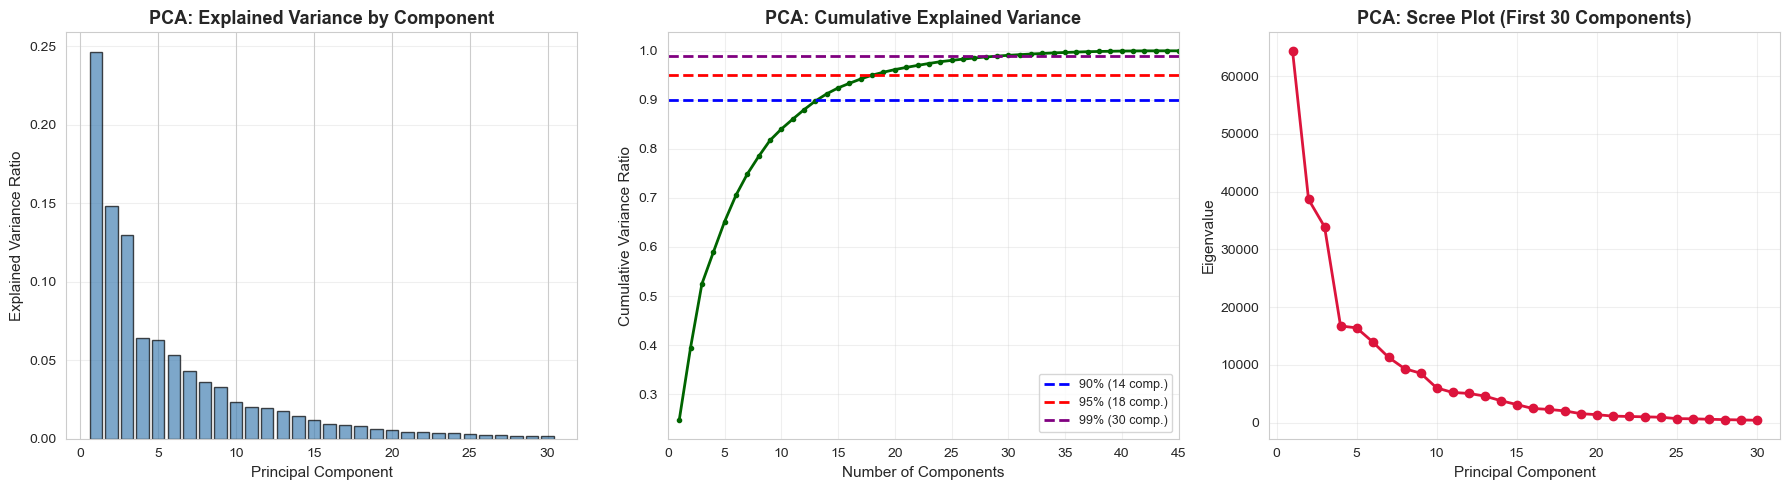

In [145]:
# ============================================================================
# 6. DIMENSIONALITY ANALYSIS WITH PCA
# ============================================================================

print("\n6. DIMENSIONALITY ANALYSIS (PCA)")
print("-" * 80)

# Perform PCA
pca_full = PCA()
pca_full.fit(X)
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find components for different variance thresholds
n_components_90 = np.argmax(cumsum_variance >= 0.90) + 1
n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1
n_components_99 = np.argmax(cumsum_variance >= 0.99) + 1

print(f"Components needed for 90% variance: {n_components_90}")
print(f"Components needed for 95% variance: {n_components_95}")
print(f"Components needed for 99% variance: {n_components_99}")
print(f"Total original features: {X.shape[1]}")
print(f"Dimensionality reduction (95%): {(1 - n_components_95/X.shape[1])*100:.1f}%")

# Visualization 6: PCA Analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: Explained variance per component
axes[0].bar(range(1, min(31, len(pca_full.explained_variance_ratio_)+1)),
            pca_full.explained_variance_ratio_[:30],
            color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('PCA: Explained Variance by Component', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Principal Component', fontsize=11)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Panel 2: Cumulative variance
axes[1].plot(range(1, len(cumsum_variance)+1), cumsum_variance,
             marker='o', linewidth=2, markersize=3, color='darkgreen')
axes[1].axhline(y=0.90, color='blue', linestyle='--', linewidth=2, 
                label=f'90% ({n_components_90} comp.)')
axes[1].axhline(y=0.95, color='red', linestyle='--', linewidth=2,
                label=f'95% ({n_components_95} comp.)')
axes[1].axhline(y=0.99, color='purple', linestyle='--', linewidth=2,
                label=f'99% ({n_components_99} comp.)')
axes[1].set_title('PCA: Cumulative Explained Variance', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Number of Components', fontsize=11)
axes[1].set_ylabel('Cumulative Variance Ratio', fontsize=11)
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, min(100, len(cumsum_variance)))

# Panel 3: Scree plot (eigenvalues)
eigenvalues = pca_full.explained_variance_[:30]
axes[2].plot(range(1, len(eigenvalues)+1), eigenvalues, 
             marker='o', linewidth=2, markersize=6, color='crimson')
axes[2].set_title('PCA: Scree Plot (First 30 Components)', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Principal Component', fontsize=11)
axes[2].set_ylabel('Eigenvalue', fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('06_pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()



7. DATA PREPROCESSING
--------------------------------------------------------------------------------
Label Encoding:
  Original labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] ... (first 10)
  Encoded range: 0 to 9
  Total classes: 10

Train/Test Split (Stratified):
  Train Set: 28,256 samples (70.0%)
  Test Set:  12,111 samples (30.0%)

Verifying Stratification:
  Max distribution difference: 0.000044
  Mean distribution difference: 0.000027
  ✓ Excellent stratification

Feature Scaling:
  StandardScaler:
    Train - Mean: 0.000000, Std: 1.000000
    Test  - Mean: -0.002912, Std: 0.989905
  RobustScaler:
    Train - Median: 0.000000
    Test  - Median: 0.000000

✓ Using StandardScaler for model training


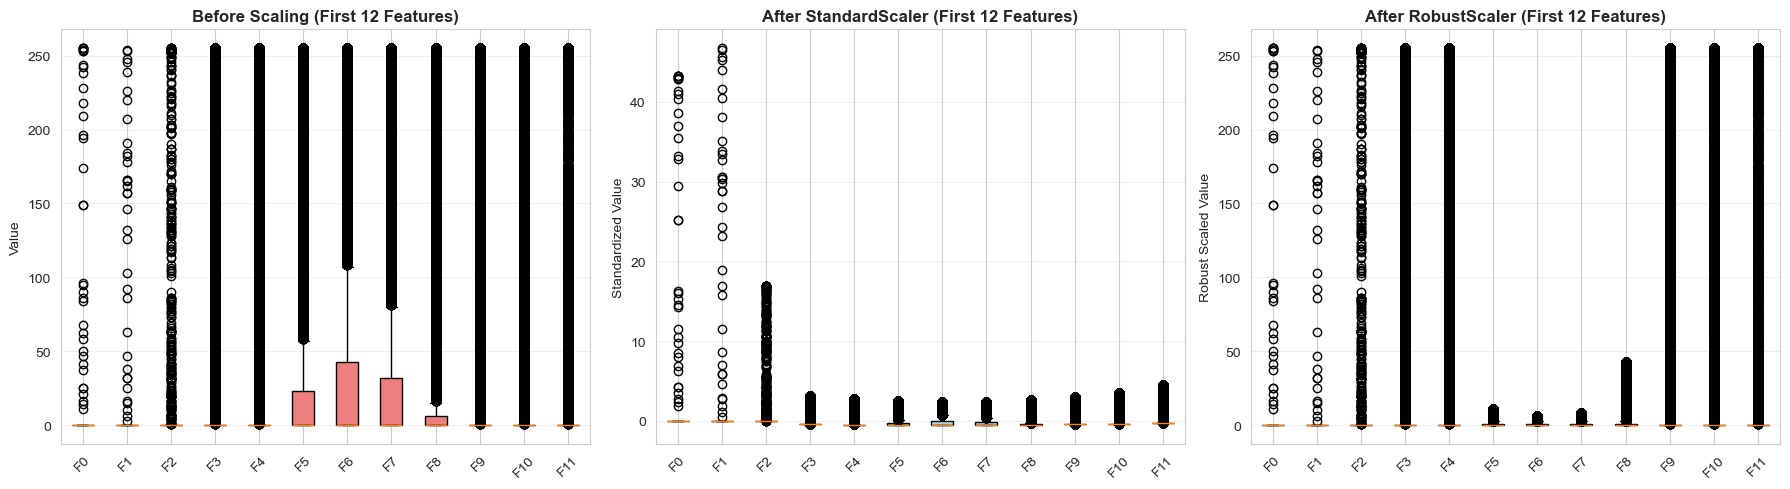

In [147]:
# ============================================================================
# 7. DATA PREPROCESSING
# ============================================================================

print("\n7. DATA PREPROCESSING")
print("-" * 80)

# Encode target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print(f"Label Encoding:")
# Convert to strings for display
display_classes = [str(label) for label in encoder.classes_]
print(f"  Original labels: {display_classes[:10]} ... (first 10)")
print(f"  Encoded range: 0 to {len(encoder.classes_)-1}")
print(f"  Total classes: {len(encoder.classes_)}")

# Train/Test Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.30, random_state=42, stratify=y_encoded
)

print(f"\nTrain/Test Split (Stratified):")
print(f"  Train Set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test Set:  {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify stratification
print("\nVerifying Stratification:")
train_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
test_dist = pd.Series(y_test).value_counts(normalize=True).sort_index()
max_diff = np.abs(train_dist - test_dist).max()
mean_diff = np.abs(train_dist - test_dist).mean()
print(f"  Max distribution difference: {max_diff:.6f}")
print(f"  Mean distribution difference: {mean_diff:.6f}")
if max_diff < 0.01:
    print("  ✓ Excellent stratification")
elif max_diff < 0.02:
    print("  ✓ Good stratification")
else:
    print("  ⚠ Adequate stratification")

# Feature Scaling
print("\nFeature Scaling:")
scaler_standard = StandardScaler()
scaler_robust = RobustScaler()

X_train_standard = scaler_standard.fit_transform(X_train)
X_test_standard = scaler_standard.transform(X_test)

X_train_robust = scaler_robust.fit_transform(X_train)
X_test_robust = scaler_robust.transform(X_test)

print(f"  StandardScaler:")
print(f"    Train - Mean: {X_train_standard.mean():.6f}, Std: {X_train_standard.std():.6f}")
print(f"    Test  - Mean: {X_test_standard.mean():.6f}, Std: {X_test_standard.std():.6f}")
print(f"  RobustScaler:")
print(f"    Train - Median: {np.median(X_train_robust):.6f}")
print(f"    Test  - Median: {np.median(X_test_robust):.6f}")

# Use StandardScaler for main analysis
X_train_scaled = X_train_standard
X_test_scaled = X_test_standard

print("\n✓ Using StandardScaler for model training")

# Visualization 7: Scaling Comparison (3 methods)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sample_indices = range(min(12, X_train.shape[1]))

# Before scaling
bp1 = axes[0].boxplot([X_train.iloc[:, i] for i in sample_indices],
                      labels=[f'F{i}' for i in sample_indices], patch_artist=True)
for patch in bp1['boxes']:
    patch.set_facecolor('lightcoral')
axes[0].set_title('Before Scaling (First 12 Features)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Value', fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# After StandardScaler
bp2 = axes[1].boxplot([X_train_scaled[:, i] for i in sample_indices],
                      labels=[f'F{i}' for i in sample_indices], patch_artist=True)
for patch in bp2['boxes']:
    patch.set_facecolor('lightblue')
axes[1].set_title('After StandardScaler (First 12 Features)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Standardized Value', fontsize=10)
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# After RobustScaler
bp3 = axes[2].boxplot([X_train_robust[:, i] for i in sample_indices],
                      labels=[f'F{i}' for i in sample_indices], patch_artist=True)
for patch in bp3['boxes']:
    patch.set_facecolor('lightgreen')
axes[2].set_title('After RobustScaler (First 12 Features)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Robust Scaled Value', fontsize=10)
axes[2].grid(axis='y', alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('07_scaling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


PART 1: K-NEAREST NEIGHBORS (KNN) MODEL

Finding optimal K value (5-fold cross-validation)...
------------------------------------------------------------
K= 1: CV Accuracy = 0.5976 (+/- 0.0028)
K= 3: CV Accuracy = 0.6142 (+/- 0.0053)
K= 5: CV Accuracy = 0.6348 (+/- 0.0062)
K= 7: CV Accuracy = 0.6408 (+/- 0.0051)
K= 9: CV Accuracy = 0.6439 (+/- 0.0049)
K=11: CV Accuracy = 0.6460 (+/- 0.0052)
K=13: CV Accuracy = 0.6464 (+/- 0.0047)
K=15: CV Accuracy = 0.6446 (+/- 0.0041)
K=17: CV Accuracy = 0.6430 (+/- 0.0057)
K=19: CV Accuracy = 0.6436 (+/- 0.0059)
------------------------------------------------------------
✓ Optimal K value: 13
✓ Best CV Accuracy: 0.6464


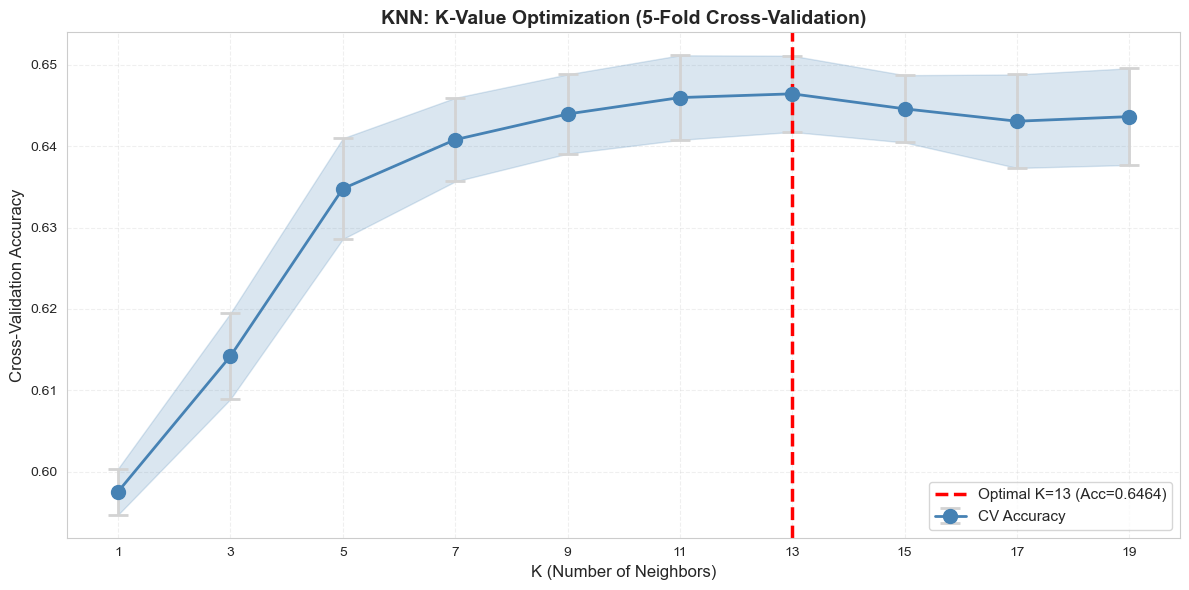


Training final KNN model (K=13)...

KNN MODEL PERFORMANCE:
Training Accuracy:    0.6941 (69.41%)
Test Accuracy:        0.6486 (64.86%)
Precision (Weighted): 0.6501
Recall (Weighted):    0.6486
F1-Score (Weighted):  0.6416

Overfitting Analysis:
  Train-Test Gap: 0.0455 (4.55%)
  ✓ Model generalizes well (low overfitting)


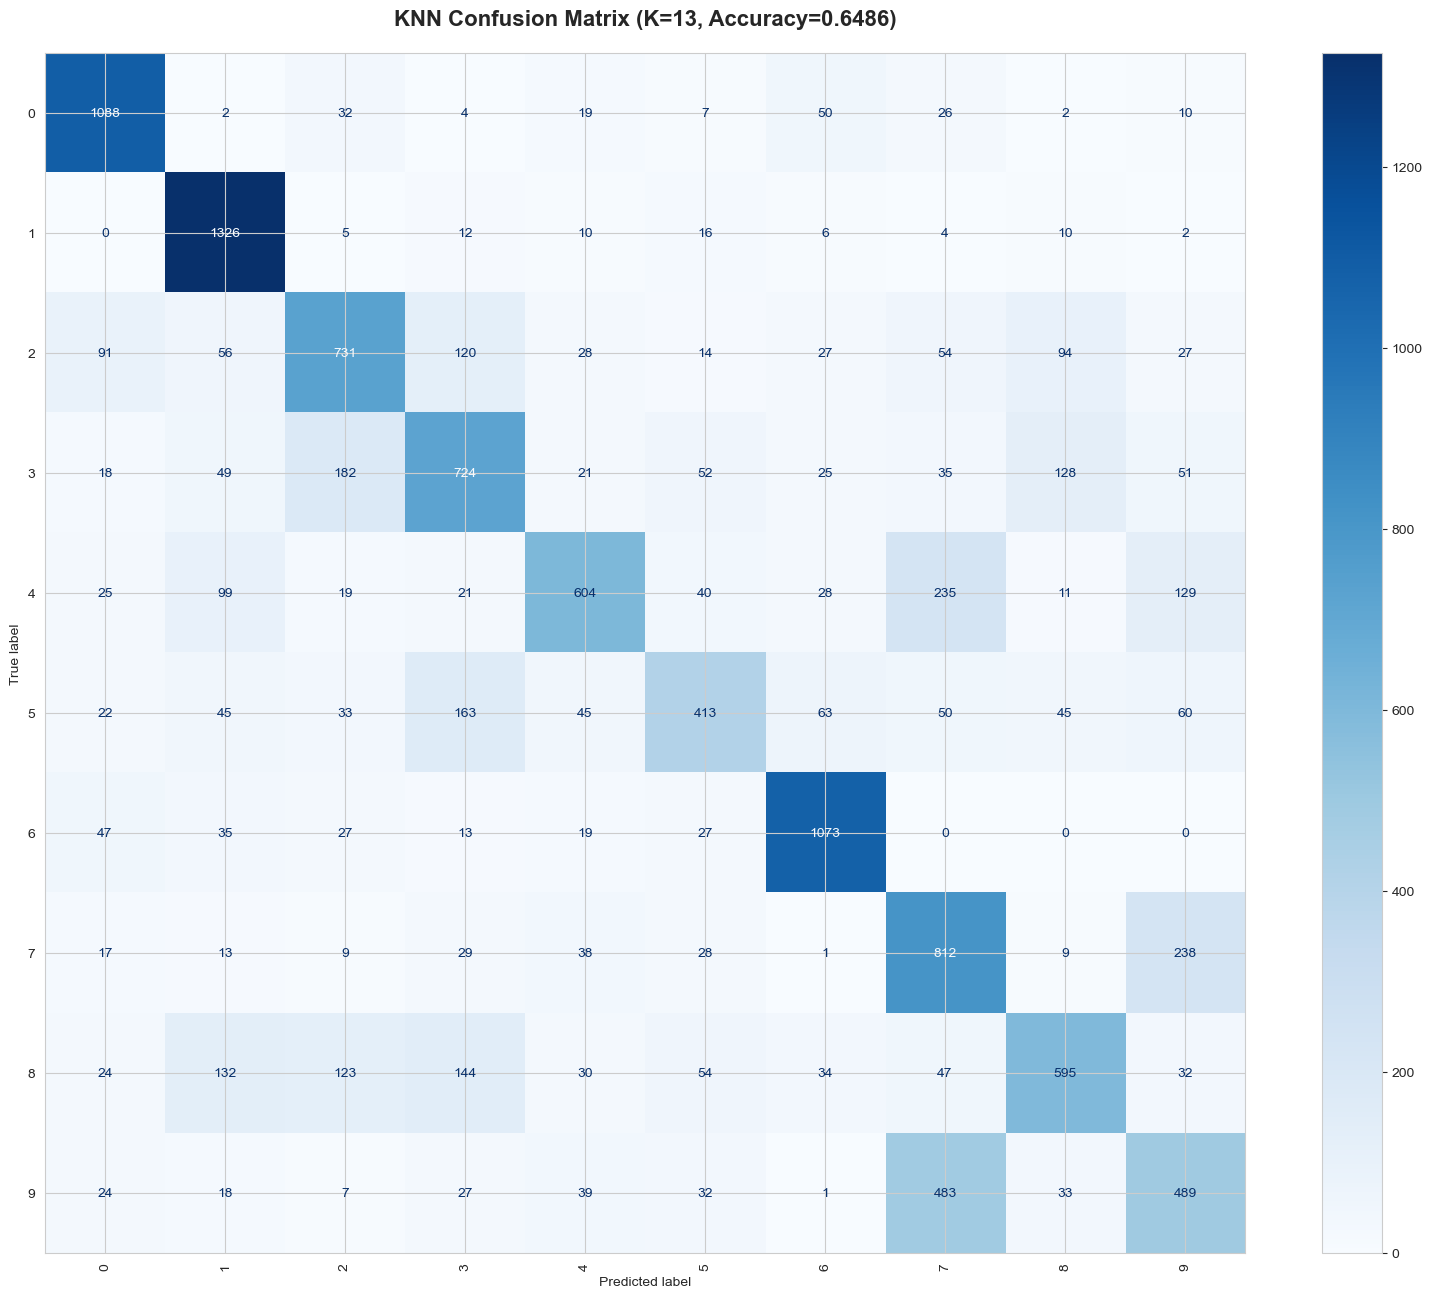

In [149]:
# ============================================================================
# 8. PART 1: K-NEAREST NEIGHBORS (KNN) MODEL
# ============================================================================

print("\n" + "="*80)
print("PART 1: K-NEAREST NEIGHBORS (KNN) MODEL")
print("="*80)

# Find optimal K using cross-validation
k_values = list(range(1, 21, 2))
cv_scores = []
cv_stds = []

print("\nFinding optimal K value (5-fold cross-validation)...")
print("-" * 60)
for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_temp, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    cv_stds.append(scores.std())
    print(f"K={k:2d}: CV Accuracy = {scores.mean():.4f} (+/- {scores.std():.4f})")

optimal_k = k_values[np.argmax(cv_scores)]
optimal_k_score = max(cv_scores)

print("-" * 60)
print(f"✓ Optimal K value: {optimal_k}")
print(f"✓ Best CV Accuracy: {optimal_k_score:.4f}")

# Visualization 8: K-Value Optimization
plt.figure(figsize=(12, 6))
plt.errorbar(k_values, cv_scores, yerr=cv_stds, marker='o', linewidth=2,
             markersize=10, color='steelblue', ecolor='lightgray', 
             capsize=7, capthick=2, label='CV Accuracy')
plt.axvline(x=optimal_k, color='red', linestyle='--', linewidth=2.5,
            label=f'Optimal K={optimal_k} (Acc={optimal_k_score:.4f})')
plt.fill_between(k_values, 
                 np.array(cv_scores) - np.array(cv_stds),
                 np.array(cv_scores) + np.array(cv_stds),
                 alpha=0.2, color='steelblue')
plt.title('KNN: K-Value Optimization (5-Fold Cross-Validation)', 
          fontsize=14, fontweight='bold')
plt.xlabel('K (Number of Neighbors)', fontsize=12)
plt.ylabel('Cross-Validation Accuracy', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=11, loc='lower right')
plt.xticks(k_values)
plt.tight_layout()
plt.savefig('08_knn_k_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Train final KNN model
print(f"\nTraining final KNN model (K={optimal_k})...")
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train_scaled, y_train)

# Predictions
knn_train_preds = knn.predict(X_train_scaled)
knn_test_preds = knn.predict(X_test_scaled)
knn_test_proba = knn.predict_proba(X_test_scaled)

# Performance metrics
knn_train_acc = accuracy_score(y_train, knn_train_preds)
knn_test_acc = accuracy_score(y_test, knn_test_preds)
knn_precision = precision_score(y_test, knn_test_preds, average='weighted')
knn_recall = recall_score(y_test, knn_test_preds, average='weighted')
knn_f1 = f1_score(y_test, knn_test_preds, average='weighted')

print("\nKNN MODEL PERFORMANCE:")
print("="*80)
print(f"Training Accuracy:    {knn_train_acc:.4f} ({knn_train_acc*100:.2f}%)")
print(f"Test Accuracy:        {knn_test_acc:.4f} ({knn_test_acc*100:.2f}%)")
print(f"Precision (Weighted): {knn_precision:.4f}")
print(f"Recall (Weighted):    {knn_recall:.4f}")
print(f"F1-Score (Weighted):  {knn_f1:.4f}")

# Overfitting analysis
overfit_score = knn_train_acc - knn_test_acc
print(f"\nOverfitting Analysis:")
print(f"  Train-Test Gap: {overfit_score:.4f} ({overfit_score*100:.2f}%)")
if overfit_score < 0.05:
    print("  ✓ Model generalizes well (low overfitting)")
    overfit_status = "Low"
elif overfit_score < 0.10:
    print("  ⚠ Slight overfitting detected")
    overfit_status = "Moderate"
else:
    print("  ⚠ Significant overfitting - model may not generalize well")
    overfit_status = "High"

# Visualization 9: KNN Confusion Matrix
plt.figure(figsize=(16, 13))
cm_knn = confusion_matrix(y_test, knn_test_preds)
# Convert class labels to strings for display
display_labels = [str(label) for label in encoder.classes_]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=display_labels)
disp.plot(cmap='Blues', ax=plt.gca(), colorbar=True, xticks_rotation='vertical')
plt.title(f'KNN Confusion Matrix (K={optimal_k}, Accuracy={knn_test_acc:.4f})',
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('09_knn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# ============================================================================
# 9. PART 2: NEURAL NETWORK MODEL
# ============================================================================

print("\n" + "="*80)
print("PART 2: NEURAL NETWORK MODEL")
print("="*80)

# Test different architectures
architectures = [
    (50,),
    (100,),
    (100, 50),
    (150, 100),
    (100, 100, 50),
    (200, 100),
]

print("\nTesting Neural Network architectures (5-fold CV)...")
print("-" * 70)
nn_cv_scores = []
nn_cv_stds = []

for arch in architectures:
    nn_temp = MLPClassifier(hidden_layer_sizes=arch, activation='relu',
                           max_iter=300, random_state=42, early_stopping=True)
    scores = cross_val_score(nn_temp, X_train_scaled, y_train, cv=5, scoring='accuracy')
    nn_cv_scores.append(scores.mean())
    nn_cv_stds.append(scores.std())
    arch_str = str(arch).ljust(20)
    print(f"Architecture {arch_str}: CV Accuracy = {scores.mean():.4f} (+/- {scores.std():.4f})")

optimal_arch = architectures[np.argmax(nn_cv_scores)]
optimal_arch_score = max(nn_cv_scores)

print("-" * 70)
print(f"✓ Optimal Architecture: {optimal_arch}")
print(f"✓ Best CV Accuracy: {optimal_arch_score:.4f}")

# Visualization 10: Architecture Comparison
plt.figure(figsize=(12, 6))
arch_labels = [str(arch) for arch in architectures]
x_pos = np.arange(len(arch_labels))
bars = plt.bar(x_pos, nn_cv_scores, yerr=nn_cv_stds, color='mediumseagreen',
               edgecolor='black', alpha=0.8, capsize=7, linewidth=1.5)
plt.axhline(y=optimal_arch_score, color='red', linestyle='--', linewidth=2,
            label=f'Best: {optimal_arch} ({optimal_arch_score:.4f})')
plt.title('Neural Network: Architecture Comparison (5-Fold CV)',
          fontsize=14, fontweight='bold')
plt.xlabel('Architecture', fontsize=12)
plt.ylabel('Cross-Validation Accuracy', fontsize=12)
plt.xticks(x_pos, arch_labels, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.legend(fontsize=10)

# Add value labels on bars
for bar, score in zip(bars, nn_cv_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.003,
            f'{score:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('10_nn_architecture_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Train final Neural Network
print(f"\nTraining final Neural Network (Architecture: {optimal_arch})...")
nn = MLPClassifier(
    hidden_layer_sizes=optimal_arch,
    activation='relu',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    verbose=False
)

nn.fit(X_train_scaled, y_train)

# Predictions
nn_train_preds = nn.predict(X_train_scaled)
nn_test_preds = nn.predict(X_test_scaled)
nn_test_proba = nn.predict_proba(X_test_scaled)

# Performance metrics
nn_train_acc = accuracy_score(y_train, nn_train_preds)
nn_test_acc = accuracy_score(y_test, nn_test_preds)
nn_precision = precision_score(y_test, nn_test_preds, average='weighted')
nn_recall = recall_score(y_test, nn_test_preds, average='weighted')
nn_f1 = f1_score(y_test, nn_test_preds, average='weighted')

print("\nNEURAL NETWORK MODEL PERFORMANCE:")
print("="*80)
print(f"Training Accuracy:    {nn_train_acc:.4f} ({nn_train_acc*100:.2f}%)")
print(f"Test Accuracy:        {nn_test_acc:.4f} ({nn_test_acc*100:.2f}%)")
print(f"Precision (Weighted): {nn_precision:.4f}")
print(f"Recall (Weighted):    {nn_recall:.4f}")
print(f"F1-Score (Weighted):  {nn_f1:.4f}")
print(f"Training Iterations:  {nn.n_iter_}")

# Overfitting analysis
nn_overfit_score = nn_train_acc - nn_test_acc
print(f"\nOverfitting Analysis:")
print(f"  Train-Test Gap: {nn_overfit_score:.4f} ({nn_overfit_score*100:.2f}%)")
if nn_overfit_score < 0.05:
    print("  ✓ Model generalizes well (low overfitting)")
    nn_overfit_status = "Low"
elif nn_overfit_score < 0.10:
    print("  ⚠ Slight overfitting detected")
    nn_overfit_status = "Moderate"
else:
    print("  ⚠ Significant overfitting - model may not generalize well")
    nn_overfit_status = "High"

# Visualization 11: NN Training History
if hasattr(nn, 'loss_curve_'):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curve
    axes[0].plot(nn.loss_curve_, linewidth=2.5, color='darkgreen', marker='o', markersize=4)
    axes[0].set_title('Neural Network: Training Loss Curve', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Iteration', fontsize=11)
    axes[0].set_ylabel('Loss', fontsize=11)
    axes[0].grid(True, alpha=0.3, linestyle='--')
    axes[0].text(0.95, 0.95, f'Final Loss: {nn.loss_curve_[-1]:.4f}',
                transform=axes[0].transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                fontsize=10, fontweight='bold')
    
    # Log-scale loss
    axes[1].semilogy(nn.loss_curve_, linewidth=2.5, color='darkgreen', marker='o', markersize=4)
    axes[1].set_title('Neural Network: Log-Scale Loss', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Iteration', fontsize=11)
    axes[1].set_ylabel('Loss (log scale)', fontsize=11)
    axes[1].grid(True, alpha=0.3, linestyle='--', which='both')
    axes[1].text(0.95, 0.95, f'Iterations: {nn.n_iter_}',
                transform=axes[1].transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5),
                fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('11_nn_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualization 12: NN Confusion Matrix
plt.figure(figsize=(16, 13))
cm_nn = confusion_matrix(y_test, nn_test_preds)
# Convert class labels to strings for display
display_labels = [str(label) for label in encoder.classes_]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=display_labels)
disp.plot(cmap='Greens', ax=plt.gca(), colorbar=True, xticks_rotation='vertical')
plt.title(f'Neural Network Confusion Matrix ({optimal_arch}, Accuracy={nn_test_acc:.4f})',
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('12_nn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()



PART 2: NEURAL NETWORK MODEL

Testing Neural Network architectures (5-fold CV)...
----------------------------------------------------------------------
Architecture (50,)               : CV Accuracy = 0.6778 (+/- 0.0052)
Architecture (100,)              : CV Accuracy = 0.6826 (+/- 0.0069)
Architecture (100, 50)           : CV Accuracy = 0.6877 (+/- 0.0062)
Architecture (150, 100)          : CV Accuracy = 0.6898 (+/- 0.0036)
Architecture (100, 100, 50)      : CV Accuracy = 0.6865 (+/- 0.0043)



10. LEARNING CURVES ANALYSIS
Generating learning curves (this may take a moment)...
  → KNN learning curve...
  → Neural Network learning curve...
✓ Learning curves generated


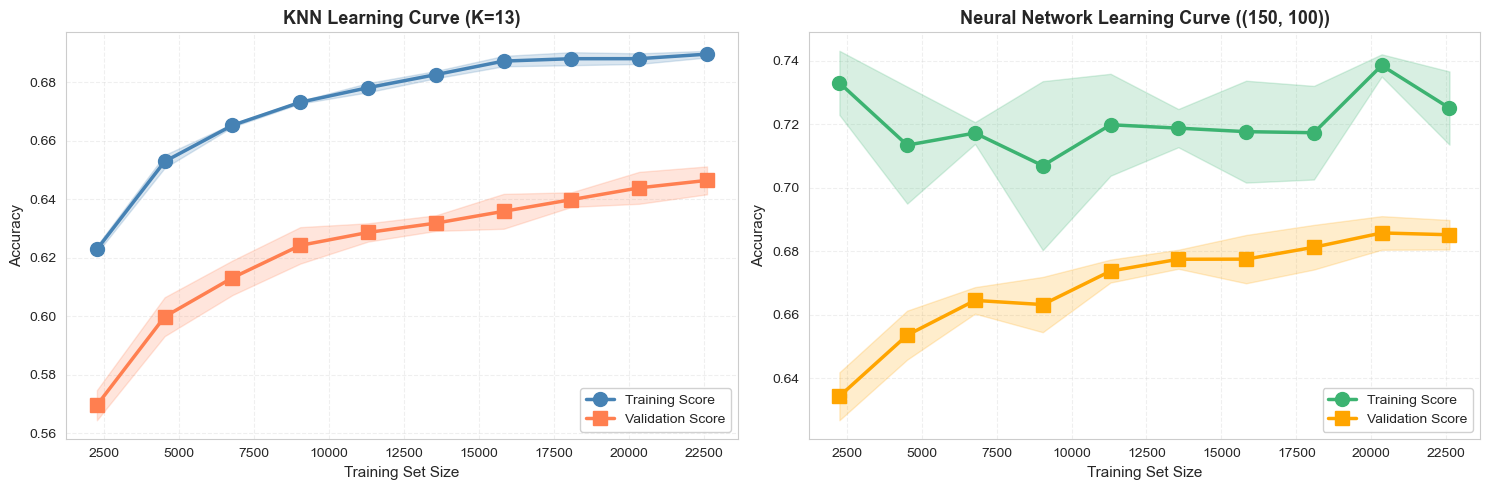

In [151]:
# ============================================================================
# 10. LEARNING CURVES ANALYSIS
# ============================================================================

print("\n10. LEARNING CURVES ANALYSIS")
print("="*80)

train_sizes = np.linspace(0.1, 1.0, 10)

print("Generating learning curves (this may take a moment)...")
print("  → KNN learning curve...")
knn_train_sizes, knn_train_scores, knn_val_scores = learning_curve(
    knn, X_train_scaled, y_train, train_sizes=train_sizes, cv=5,
    scoring='accuracy', n_jobs=-1, random_state=42
)

print("  → Neural Network learning curve...")
nn_train_sizes, nn_train_scores, nn_val_scores = learning_curve(
    nn, X_train_scaled, y_train, train_sizes=train_sizes, cv=5,
    scoring='accuracy', n_jobs=-1, random_state=42
)

print("✓ Learning curves generated")

# Visualization 13: Learning Curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# KNN Learning Curve
axes[0].plot(knn_train_sizes, knn_train_scores.mean(axis=1), 'o-',
             color='steelblue', linewidth=2.5, markersize=10, label='Training Score')
axes[0].plot(knn_train_sizes, knn_val_scores.mean(axis=1), 's-',
             color='coral', linewidth=2.5, markersize=10, label='Validation Score')
axes[0].fill_between(knn_train_sizes,
                      knn_train_scores.mean(axis=1) - knn_train_scores.std(axis=1),
                      knn_train_scores.mean(axis=1) + knn_train_scores.std(axis=1),
                      alpha=0.2, color='steelblue')
axes[0].fill_between(knn_train_sizes,
                      knn_val_scores.mean(axis=1) - knn_val_scores.std(axis=1),
                      knn_val_scores.mean(axis=1) + knn_val_scores.std(axis=1),
                      alpha=0.2, color='coral')
axes[0].set_title(f'KNN Learning Curve (K={optimal_k})', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Training Set Size', fontsize=11)
axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].legend(loc='lower right', fontsize=10, framealpha=0.9)
axes[0].grid(True, alpha=0.3, linestyle='--')

# Neural Network Learning Curve
axes[1].plot(nn_train_sizes, nn_train_scores.mean(axis=1), 'o-',
             color='mediumseagreen', linewidth=2.5, markersize=10, label='Training Score')
axes[1].plot(nn_train_sizes, nn_val_scores.mean(axis=1), 's-',
             color='orange', linewidth=2.5, markersize=10, label='Validation Score')
axes[1].fill_between(nn_train_sizes,
                      nn_train_scores.mean(axis=1) - nn_train_scores.std(axis=1),
                      nn_train_scores.mean(axis=1) + nn_train_scores.std(axis=1),
                      alpha=0.2, color='mediumseagreen')
axes[1].fill_between(nn_train_sizes,
                      nn_val_scores.mean(axis=1) - nn_val_scores.std(axis=1),
                      nn_val_scores.mean(axis=1) + nn_val_scores.std(axis=1),
                      alpha=0.2, color='orange')
axes[1].set_title(f'Neural Network Learning Curve ({optimal_arch})', 
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel('Training Set Size', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].legend(loc='lower right', fontsize=10, framealpha=0.9)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('13_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()



PART 3: COMPREHENSIVE MODEL COMPARISON

DETAILED MODEL PERFORMANCE COMPARISON:
         Model Hyperparameters  Training Accuracy  Test Accuracy  Precision   Recall  F1-Score  Overfitting Gap Overfitting Status
           KNN            K=13           0.694118       0.648584   0.650083 0.648584  0.641642         0.045534                Low
Neural Network      (150, 100)           0.720484       0.690034   0.697467 0.690034  0.689203         0.030450                Low


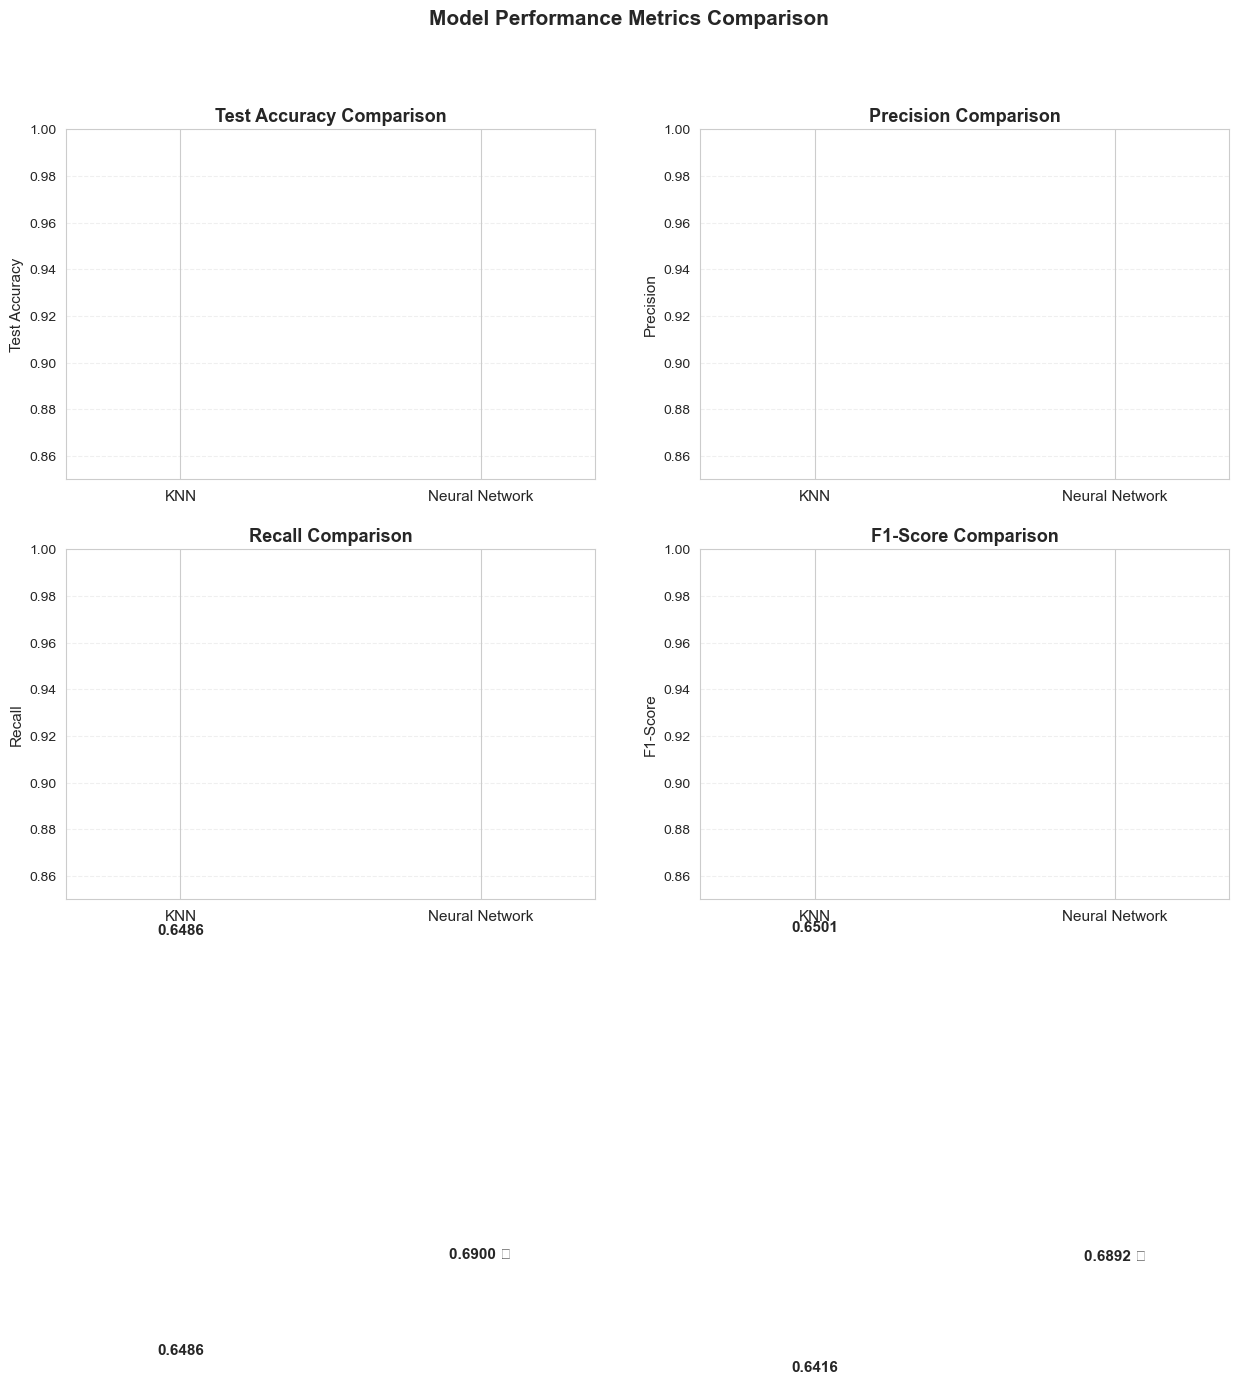

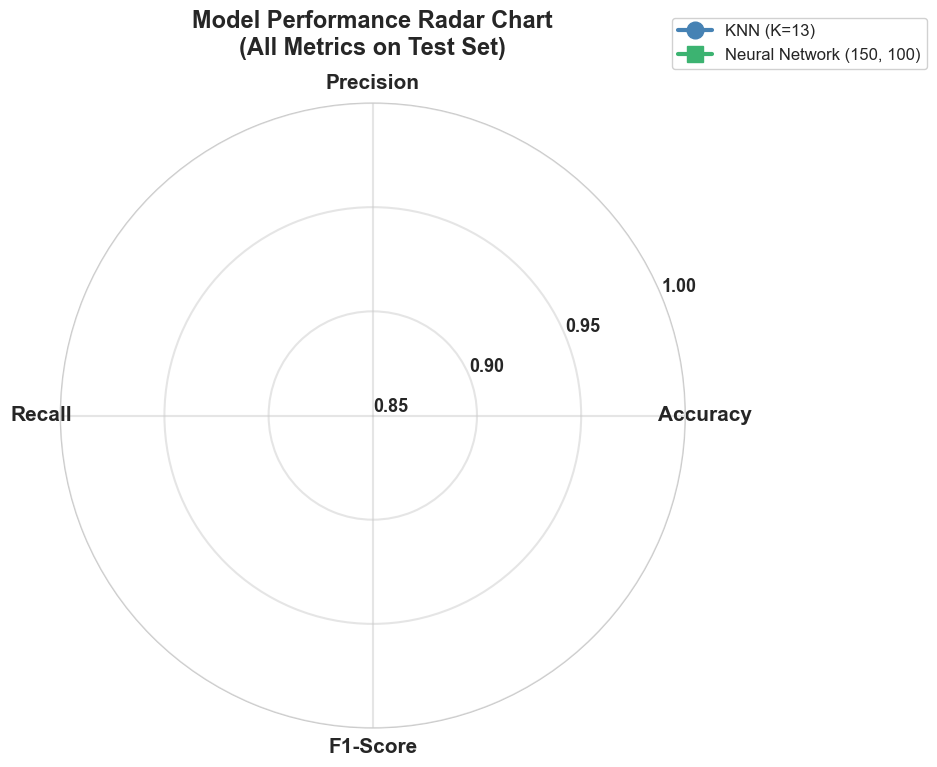

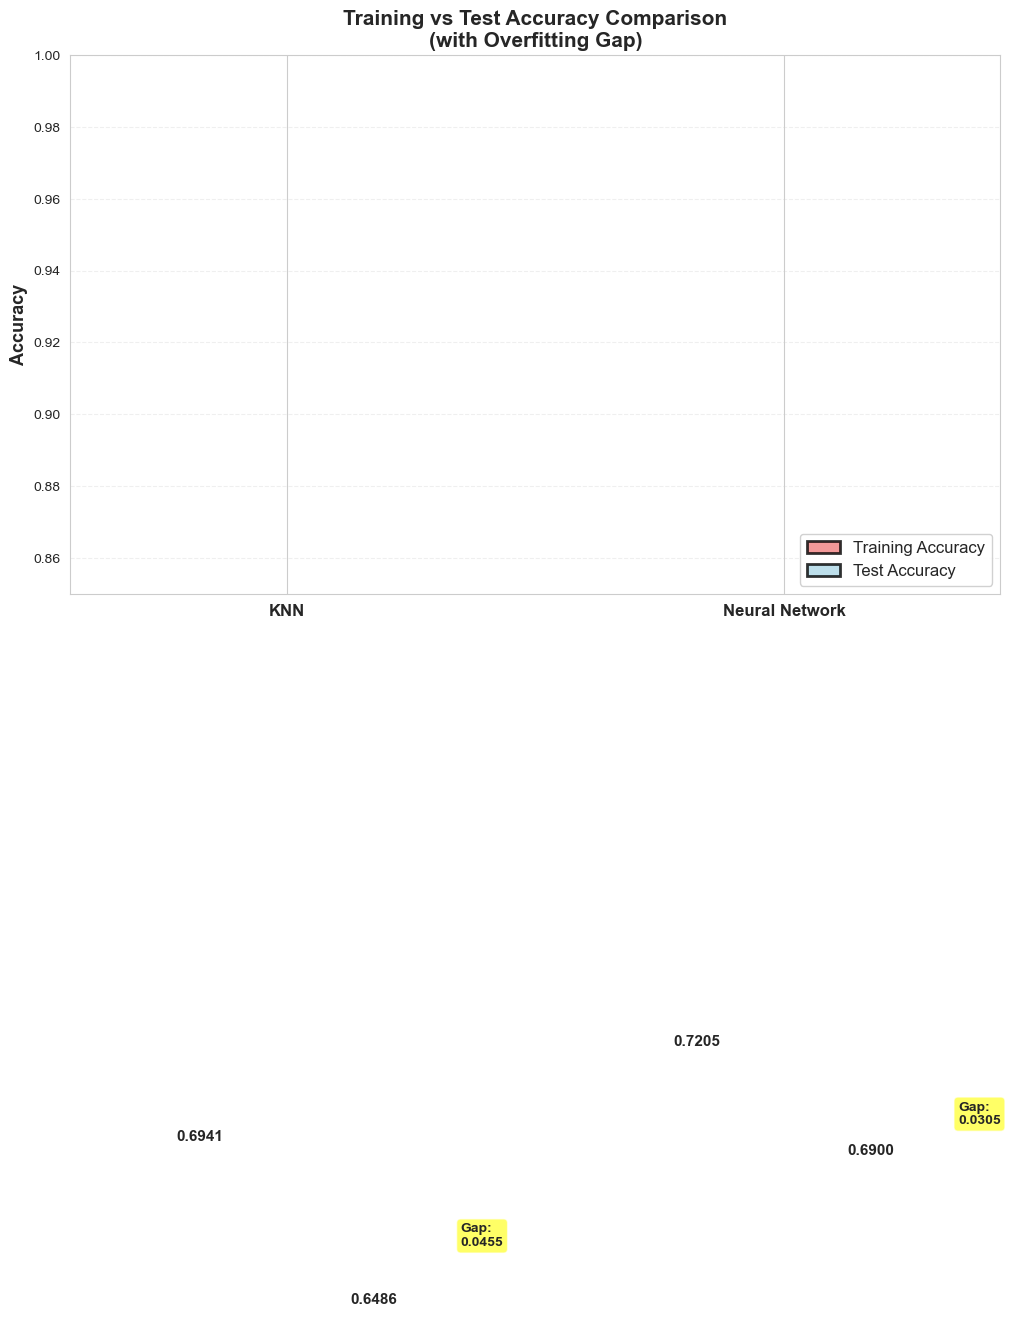

In [152]:
# ============================================================================
# 11. PART 3: COMPREHENSIVE MODEL COMPARISON
# ============================================================================

print("\n" + "="*80)
print("PART 3: COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Create detailed comparison
comparison_df = pd.DataFrame({
    'Model': ['KNN', 'Neural Network'],
    'Hyperparameters': [f'K={optimal_k}', f'{optimal_arch}'],
    'Training Accuracy': [knn_train_acc, nn_train_acc],
    'Test Accuracy': [knn_test_acc, nn_test_acc],
    'Precision': [knn_precision, nn_precision],
    'Recall': [knn_recall, nn_recall],
    'F1-Score': [knn_f1, nn_f1],
    'Overfitting Gap': [overfit_score, nn_overfit_score],
    'Overfitting Status': [overfit_status, nn_overfit_status]
})

print("\nDETAILED MODEL PERFORMANCE COMPARISON:")
print("="*80)
print(comparison_df.to_string(index=False))

# Visualization 14: Multi-Metric Comparison (4-panel)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Test Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_data = [
    [knn_test_acc, nn_test_acc],
    [knn_precision, nn_precision],
    [knn_recall, nn_recall],
    [knn_f1, nn_f1]
]
colors = ['steelblue', 'mediumseagreen']

for idx, (ax, metric, data) in enumerate(zip(axes.flatten(), metrics, metric_data)):
    x_pos = np.arange(len(['KNN', 'Neural Network']))
    bars = ax.bar(x_pos, data, color=colors, edgecolor='black', 
                  alpha=0.8, linewidth=2, width=0.6)
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.set_ylabel(metric, fontsize=11)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['KNN', 'Neural Network'], fontsize=11)
    ax.set_ylim([max(0.85, min(data) - 0.05), 1.0])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels with winner indicator
    for i, (bar, value) in enumerate(zip(bars, data)):
        height = bar.get_height()
        winner = ' ★' if value == max(data) else ''
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{value:.4f}{winner}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.suptitle('Model Performance Metrics Comparison', 
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('14_metric_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 15: Radar Chart
from math import pi

categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
knn_values = [knn_test_acc, knn_precision, knn_recall, knn_f1]
nn_values = [nn_test_acc, nn_precision, nn_recall, nn_f1]

N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
knn_values_plot = knn_values + knn_values[:1]
nn_values_plot = nn_values + nn_values[:1]
angles_plot = angles + angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Plot KNN
ax.plot(angles_plot, knn_values_plot, 'o-', linewidth=3, label=f'KNN (K={optimal_k})',
        color='steelblue', markersize=12)
ax.fill(angles_plot, knn_values_plot, alpha=0.25, color='steelblue')

# Plot NN
ax.plot(angles_plot, nn_values_plot, 's-', linewidth=3, 
        label=f'Neural Network {optimal_arch}',
        color='mediumseagreen', markersize=12)
ax.fill(angles_plot, nn_values_plot, alpha=0.25, color='mediumseagreen')

ax.set_xticks(angles)
ax.set_xticklabels(categories, size=15, fontweight='bold')
ax.set_ylim(0.85, 1.0)
ax.set_yticks([0.85, 0.90, 0.95, 1.0])
ax.set_yticklabels(['0.85', '0.90', '0.95', '1.00'], size=13, fontweight='bold')
ax.set_title('Model Performance Radar Chart\n(All Metrics on Test Set)',
             fontsize=17, fontweight='bold', pad=35)
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.15), fontsize=12, framealpha=0.9)
ax.grid(True, linewidth=1.5, alpha=0.5)

plt.tight_layout()
plt.savefig('15_radar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 16: Train vs Test Accuracy with Overfitting Indicator
fig, ax = plt.subplots(figsize=(12, 7))

models = ['KNN', 'Neural Network']
train_scores = [knn_train_acc, nn_train_acc]
test_scores = [knn_test_acc, nn_test_acc]
gaps = [overfit_score, nn_overfit_score]

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, train_scores, width, label='Training Accuracy',
               color='lightcoral', edgecolor='black', linewidth=2, alpha=0.8)
bars2 = ax.bar(x + width/2, test_scores, width, label='Test Accuracy',
               color='lightblue', edgecolor='black', linewidth=2, alpha=0.8)

# Add gap annotations
for i, (train, test, gap) in enumerate(zip(train_scores, test_scores, gaps)):
    mid_x = x[i]
    ax.plot([mid_x, mid_x], [test, train], 'k--', linewidth=1.5, alpha=0.5)
    ax.text(mid_x + 0.35, (train + test) / 2, f'Gap:\n{gap:.4f}',
            ha='left', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.6))

ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax.set_title('Training vs Test Accuracy Comparison\n(with Overfitting Gap)',
             fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12, fontweight='bold')
ax.legend(fontsize=12, loc='lower right', framealpha=0.9)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0.85, 1.0])

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.003,
                f'{height:.4f}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('16_train_test_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



12. ERROR ANALYSIS

KNN - Detailed Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8024    0.8774    0.8382      1240
           1     0.7470    0.9533    0.8377      1391
           2     0.6259    0.5886    0.6066      1242
           3     0.5760    0.5634    0.5696      1285
           4     0.7081    0.4988    0.5853      1211
           5     0.6047    0.4398    0.5092       939
           6     0.8203    0.8646    0.8419      1241
           7     0.4651    0.6801    0.5524      1194
           8     0.6419    0.4897    0.5556      1215
           9     0.4711    0.4241    0.4464      1153

    accuracy                         0.6486     12111
   macro avg     0.6462    0.6380    0.6343     12111
weighted avg     0.6501    0.6486    0.6416     12111


Neural Network - Detailed Classification Report:
---------------------------------------------------

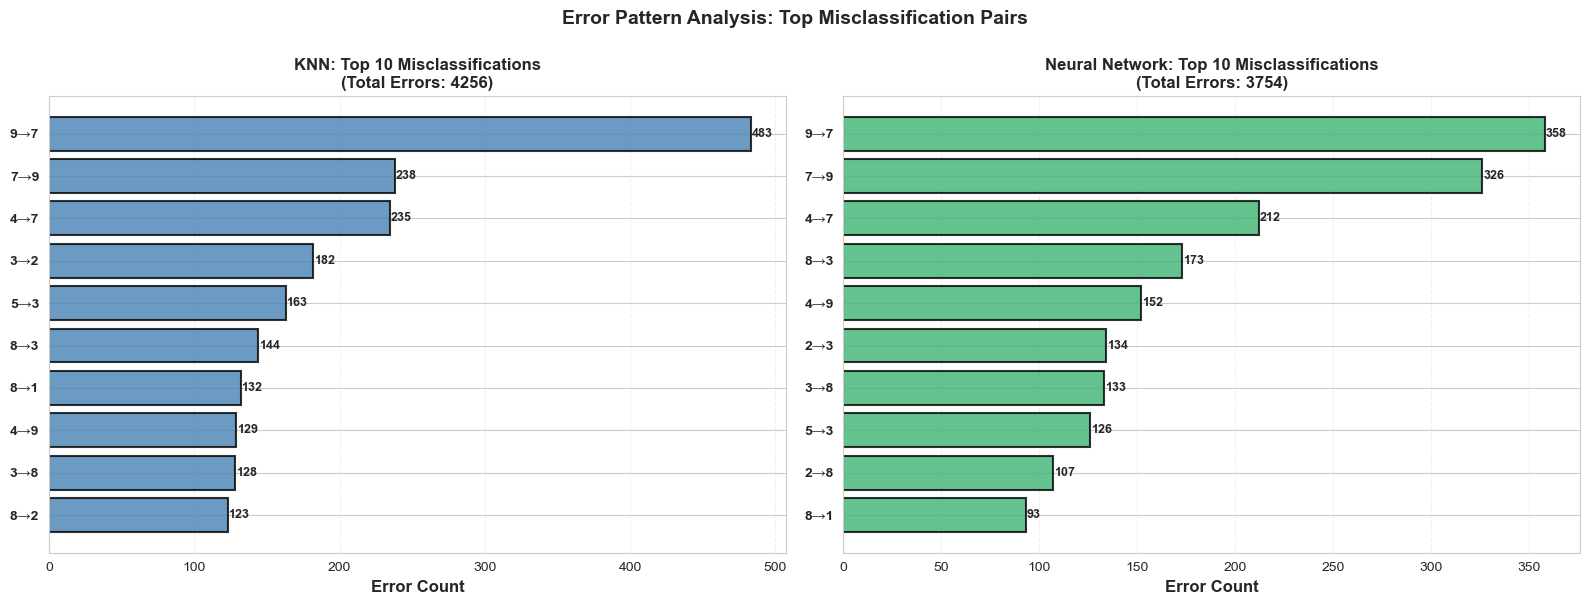


Generating per-class performance visualization...


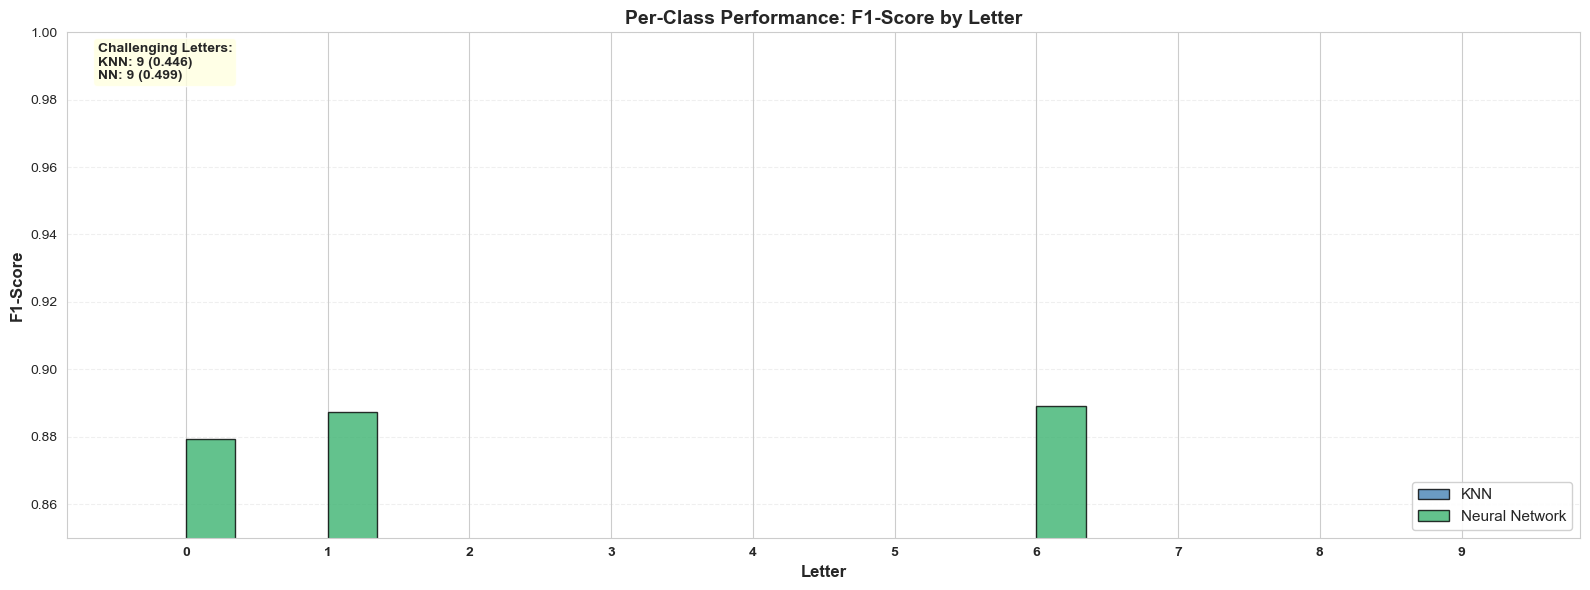

In [154]:
# ============================================================================
# 12. ERROR ANALYSIS
# ============================================================================

print("\n12. ERROR ANALYSIS")
print("="*80)

# Classification reports
print("\nKNN - Detailed Classification Report:")
print("-" * 80)
# Convert class labels to strings if they're numeric
target_names = [str(label) for label in encoder.classes_]
knn_report = classification_report(y_test, knn_test_preds, 
                                    target_names=target_names, digits=4)
print(knn_report)

print("\nNeural Network - Detailed Classification Report:")
print("-" * 80)
nn_report = classification_report(y_test, nn_test_preds,
                                   target_names=target_names, digits=4)
print(nn_report)

# Most confused pairs
def get_most_confused_pairs(cm, labels, top_n=10):
    """Extract most confused class pairs"""
    confused_pairs = []
    for i in range(len(cm)):
        for j in range(len(cm)):
            if i != j and cm[i, j] > 0:
                confused_pairs.append((labels[i], labels[j], cm[i, j]))
    return sorted(confused_pairs, key=lambda x: x[2], reverse=True)[:top_n]

# Convert class labels to strings for display
display_labels = [str(label) for label in encoder.classes_]
knn_confused = get_most_confused_pairs(cm_knn, display_labels, 10)
nn_confused = get_most_confused_pairs(cm_nn, display_labels, 10)

print("\nTop 10 Most Confused Letter Pairs - KNN:")
print("-" * 50)
for idx, (true_label, pred_label, count) in enumerate(knn_confused, 1):
    pct = (count / len(y_test)) * 100
    print(f"{idx:2d}. {true_label} → {pred_label}: {count:3d} errors ({pct:.2f}%)")

print("\nTop 10 Most Confused Letter Pairs - Neural Network:")
print("-" * 50)
for idx, (true_label, pred_label, count) in enumerate(nn_confused, 1):
    pct = (count / len(y_test)) * 100
    print(f"{idx:2d}. {true_label} → {pred_label}: {count:3d} errors ({pct:.2f}%)")

# Visualization 17: Error Analysis Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# KNN errors
knn_errors_labels = [f"{pair[0]}→{pair[1]}" for pair in knn_confused]
knn_errors_count = [pair[2] for pair in knn_confused]
y_pos = np.arange(len(knn_errors_labels))
bars1 = axes[0].barh(y_pos, knn_errors_count, color='steelblue',
                     edgecolor='black', alpha=0.8, linewidth=1.5)
axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(knn_errors_labels, fontsize=10, fontweight='bold')
axes[0].set_xlabel('Error Count', fontsize=12, fontweight='bold')
axes[0].set_title(f'KNN: Top 10 Misclassifications\n(Total Errors: {len(y_test) - (y_test == knn_test_preds).sum()})',
                  fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3, linestyle='--')
axes[0].invert_yaxis()

# Add value labels
for bar, count in zip(bars1, knn_errors_count):
    width = bar.get_width()
    axes[0].text(width + 0.5, bar.get_y() + bar.get_height()/2.,
                f'{count}', ha='left', va='center', fontweight='bold', fontsize=9)

# NN errors
nn_errors_labels = [f"{pair[0]}→{pair[1]}" for pair in nn_confused]
nn_errors_count = [pair[2] for pair in nn_confused]
y_pos = np.arange(len(nn_errors_labels))
bars2 = axes[1].barh(y_pos, nn_errors_count, color='mediumseagreen',
                     edgecolor='black', alpha=0.8, linewidth=1.5)
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(nn_errors_labels, fontsize=10, fontweight='bold')
axes[1].set_xlabel('Error Count', fontsize=12, fontweight='bold')
axes[1].set_title(f'Neural Network: Top 10 Misclassifications\n(Total Errors: {len(y_test) - (y_test == nn_test_preds).sum()})',
                  fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3, linestyle='--')
axes[1].invert_yaxis()

# Add value labels
for bar, count in zip(bars2, nn_errors_count):
    width = bar.get_width()
    axes[1].text(width + 0.5, bar.get_y() + bar.get_height()/2.,
                f'{count}', ha='left', va='center', fontweight='bold', fontsize=9)

plt.suptitle('Error Pattern Analysis: Top Misclassification Pairs',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('17_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 18: Per-Class Performance Comparison
print("\nGenerating per-class performance visualization...")
# Convert class labels to strings if they're numeric
target_names = [str(label) for label in encoder.classes_]
knn_report_dict = classification_report(y_test, knn_test_preds, 
                                         target_names=target_names, 
                                         output_dict=True)
nn_report_dict = classification_report(y_test, nn_test_preds,
                                        target_names=target_names,
                                        output_dict=True)

# Extract per-class F1 scores
letters = target_names
knn_f1_per_class = [knn_report_dict[letter]['f1-score'] for letter in letters]
nn_f1_per_class = [nn_report_dict[letter]['f1-score'] for letter in letters]

fig, ax = plt.subplots(figsize=(16, 6))
x = np.arange(len(letters))
width = 0.35

bars1 = ax.bar(x - width/2, knn_f1_per_class, width, label='KNN',
               color='steelblue', edgecolor='black', alpha=0.8)
bars2 = ax.bar(x + width/2, nn_f1_per_class, width, label='Neural Network',
               color='mediumseagreen', edgecolor='black', alpha=0.8)

ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_xlabel('Letter', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Performance: F1-Score by Letter', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(letters, fontsize=10, fontweight='bold')
ax.legend(fontsize=11, loc='lower right', framealpha=0.9)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0.85, 1.0])

# Highlight best and worst performers
worst_knn = letters[np.argmin(knn_f1_per_class)]
worst_nn = letters[np.argmin(nn_f1_per_class)]
ax.text(0.02, 0.98, f'Challenging Letters:\nKNN: {worst_knn} ({min(knn_f1_per_class):.3f})\nNN: {worst_nn} ({min(nn_f1_per_class):.3f})',
        transform=ax.transAxes, ha='left', va='top',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
        fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('18_per_class_performance.png', dpi=300, bbox_inches='tight')
plt.show()


In [155]:
# ============================================================================
# 13. FINAL RECOMMENDATION
# ============================================================================

print("\n" + "="*80)
print("FINAL RECOMMENDATION & CONCLUSION")
print("="*80)

# Performance summary by criterion
criteria_scores = {
    'Test Accuracy': {'KNN': knn_test_acc, 'NN': nn_test_acc},
    'Precision': {'KNN': knn_precision, 'NN': nn_precision},
    'Recall': {'KNN': knn_recall, 'NN': nn_recall},
    'F1-Score': {'KNN': knn_f1, 'NN': nn_f1},
    'Generalization': {'KNN': -overfit_score, 'NN': -nn_overfit_score}
}

print("\nPerformance by Criterion:")
print("-" * 70)
wins = {'KNN': 0, 'NN': 0}
for criterion, scores in criteria_scores.items():
    winner = 'Neural Network' if scores['NN'] > scores['KNN'] else 'KNN'
    winner_short = 'NN' if winner == 'Neural Network' else 'KNN'
    wins[winner_short] += 1
    diff = abs(scores['NN'] - scores['KNN'])
    print(f"{criterion:20s}: {winner:15s} ★ "
          f"(KNN: {scores['KNN']:.4f}, NN: {scores['NN']:.4f}, Δ: {diff:.4f})")

print("-" * 70)
print(f"Criteria Won - KNN: {wins['KNN']}, Neural Network: {wins['NN']}")

# Overall performance score
nn_score = (nn_test_acc + nn_precision + nn_f1 + nn_recall) / 4
knn_score = (knn_test_acc + knn_precision + knn_f1 + knn_recall) / 4

print(f"\nOverall Performance Score (Average of Key Metrics):")
print(f"  KNN:            {knn_score:.4f}")
print(f"  Neural Network: {nn_score:.4f}")
print(f"  Difference:     {abs(nn_score - knn_score):.4f} ({abs(nn_score - knn_score)*100:.2f}%)")

# Make recommendation
if nn_score > knn_score:
    recommended_model = "Neural Network"
    advantage = nn_score - knn_score
else:
    recommended_model = "KNN"
    advantage = knn_score - nn_score

print("\n" + "="*80)
print(f"★ RECOMMENDED MODEL: {recommended_model} ★")
print("="*80)

if recommended_model == "Neural Network":
    print(f"\nModel Configuration:")
    print(f"  Architecture: {optimal_arch}")
    print(f"  Test Accuracy: {nn_test_acc:.4f} ({nn_test_acc*100:.2f}%)")
    print(f"  Training Iterations: {nn.n_iter_}")
    print(f"  Performance Advantage: {advantage:.4f} ({advantage*100:.2f}%)")
    
    print(f"\nKey Strengths:")
    print(f"  ✓ Higher overall performance across metrics")
    print(f"  ✓ Better pattern recognition for complex handwriting variations")
    print(f"  ✓ Learns hierarchical features through multiple layers")
    print(f"  ✓ More robust to noise and variations in letter formation")
    
    print(f"\nPractical Implications for School:")
    print(f"  • More accurate identification of students needing motor skill support")
    print(f"  • Better handles variations in children's handwriting")
    print(f"  • Can detect subtle patterns indicating developmental concerns")
    print(f"  • Suitable for automated screening with high confidence")
else:
    print(f"\nModel Configuration:")
    print(f"  Optimal K: {optimal_k}")
    print(f"  Test Accuracy: {knn_test_acc:.4f} ({knn_test_acc*100:.2f}%)")
    print(f"  Performance Advantage: {advantage:.4f} ({advantage*100:.2f}%)")
    
    print(f"\nKey Strengths:")
    print(f"  ✓ Simpler model with comparable performance")
    print(f"  ✓ More interpretable - distance-based classification")
    print(f"  ✓ Easier to explain to non-technical stakeholders")
    print(f"  ✓ Lower computational requirements for deployment")
    print(f"  ✓ No training time required")
    
    print(f"\nPractical Implications for School:")
    print(f"  • Reliable screening tool with transparent methodology")
    print(f"  • Easier for teachers to understand how decisions are made")
    print(f"  • Lower maintenance and computational costs")
    print(f"  • Quick to deploy and update with new samples")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

print("\nGenerated Files:")
print("  ✓ 18 high-resolution visualizations (300 DPI)")
print("    - Data quality & cleaning reports")
print("    - Feature analysis & preprocessing")
print("    - Model optimization & training")
print("    - Performance comparison & error analysis")
print("  ✓ model_comparison_summary.csv")
print("  ✓ Complete console output for methodology documentation")



FINAL RECOMMENDATION & CONCLUSION

Performance by Criterion:
----------------------------------------------------------------------
Test Accuracy       : Neural Network  ★ (KNN: 0.6486, NN: 0.6900, Δ: 0.0414)
Precision           : Neural Network  ★ (KNN: 0.6501, NN: 0.6975, Δ: 0.0474)
Recall              : Neural Network  ★ (KNN: 0.6486, NN: 0.6900, Δ: 0.0414)
F1-Score            : Neural Network  ★ (KNN: 0.6416, NN: 0.6892, Δ: 0.0476)
Generalization      : Neural Network  ★ (KNN: -0.0455, NN: -0.0305, Δ: 0.0151)
----------------------------------------------------------------------
Criteria Won - KNN: 0, Neural Network: 5

Overall Performance Score (Average of Key Metrics):
  KNN:            0.6472
  Neural Network: 0.6917
  Difference:     0.0445 (4.45%)

★ RECOMMENDED MODEL: Neural Network ★

Model Configuration:
  Architecture: (150, 100)
  Test Accuracy: 0.6900 (69.00%)
  Training Iterations: 28
  Performance Advantage: 0.0445 (4.45%)

Key Strengths:
  ✓ Higher overall performanc